In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 30
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_glcm_Contrast_glcm_Correlation_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortR

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 558)
(3944610, 8)
validation
(464344, 558)
(464344, 8)
test
(574820, 558)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 558)]             0         


 dense (Dense)               (None, 1024)              572416    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1262472 (4.82 MB)


Trainable params: 1262472 (4.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



  1/395 [..............................] - ETA: 8:58 - loss: 2.3383 - STD: 0.0935 - MAE: 0.2192


  5/395 [..............................] - ETA: 6s - loss: 2.1368 - STD: 0.0553 - MAE: 0.2171  


  9/395 [..............................] - ETA: 5s - loss: 2.1208 - STD: 0.0541 - MAE: 0.2166


 13/395 [..............................] - ETA: 5s - loss: 2.1029 - STD: 0.0499 - MAE: 0.2166


 17/395 [>.............................] - ETA: 5s - loss: 2.0926 - STD: 0.0449 - MAE: 0.2167


 21/395 [>.............................] - ETA: 5s - loss: 2.0864 - STD: 0.0425 - MAE: 0.2167


 25/395 [>.............................] - ETA: 5s - loss: 2.0802 - STD: 0.0415 - MAE: 0.2167


 29/395 [=>............................] - ETA: 5s - loss: 2.0756 - STD: 0.0403 - MAE: 0.2166


 33/395 [=>............................] - ETA: 5s - loss: 2.0714 - STD: 0.0396 - MAE: 0.2166


 37/395 [=>............................] - ETA: 5s - loss: 2.0672 - STD: 0.0393 - MAE: 0.2165


 41/395 [==>...........................] - ETA: 5s - loss: 2.0621 - STD: 0.0385 - MAE: 0.2164


 45/395 [==>...........................] - ETA: 5s - loss: 2.0558 - STD: 0.0385 - MAE: 0.2162


 49/395 [==>...........................] - ETA: 4s - loss: 2.0477 - STD: 0.0392 - MAE: 0.2159


 53/395 [===>..........................] - ETA: 4s - loss: 2.0385 - STD: 0.0407 - MAE: 0.2154


 57/395 [===>..........................] - ETA: 4s - loss: 2.0288 - STD: 0.0424 - MAE: 0.2149


 61/395 [===>..........................] - ETA: 4s - loss: 2.0184 - STD: 0.0442 - MAE: 0.2144


 65/395 [===>..........................] - ETA: 4s - loss: 2.0074 - STD: 0.0459 - MAE: 0.2139


 69/395 [====>.........................] - ETA: 4s - loss: 1.9953 - STD: 0.0477 - MAE: 0.2133


 73/395 [====>.........................] - ETA: 4s - loss: 1.9816 - STD: 0.0496 - MAE: 0.2126


 77/395 [====>.........................] - ETA: 4s - loss: 1.9675 - STD: 0.0516 - MAE: 0.2119


 81/395 [=====>........................] - ETA: 4s - loss: 1.9525 - STD: 0.0537 - MAE: 0.2111


 85/395 [=====>........................] - ETA: 4s - loss: 1.9366 - STD: 0.0560 - MAE: 0.2102


 89/395 [=====>........................] - ETA: 4s - loss: 1.9201 - STD: 0.0584 - MAE: 0.2093


 93/395 [======>.......................] - ETA: 4s - loss: 1.9037 - STD: 0.0610 - MAE: 0.2083


 97/395 [======>.......................] - ETA: 4s - loss: 1.8878 - STD: 0.0636 - MAE: 0.2073


101/395 [======>.......................] - ETA: 4s - loss: 1.8726 - STD: 0.0661 - MAE: 0.2064


105/395 [======>.......................] - ETA: 4s - loss: 1.8579 - STD: 0.0685 - MAE: 0.2055


109/395 [=======>......................] - ETA: 4s - loss: 1.8439 - STD: 0.0708 - MAE: 0.2046


113/395 [=======>......................] - ETA: 3s - loss: 1.8306 - STD: 0.0730 - MAE: 0.2037


117/395 [=======>......................] - ETA: 3s - loss: 1.8179 - STD: 0.0752 - MAE: 0.2028


121/395 [========>.....................] - ETA: 3s - loss: 1.8056 - STD: 0.0772 - MAE: 0.2020


125/395 [========>.....................] - ETA: 3s - loss: 1.7939 - STD: 0.0791 - MAE: 0.2012


129/395 [========>.....................] - ETA: 3s - loss: 1.7826 - STD: 0.0810 - MAE: 0.2005


133/395 [=========>....................] - ETA: 3s - loss: 1.7717 - STD: 0.0828 - MAE: 0.1997


137/395 [=========>....................] - ETA: 3s - loss: 1.7612 - STD: 0.0846 - MAE: 0.1990


141/395 [=========>....................] - ETA: 3s - loss: 1.7513 - STD: 0.0863 - MAE: 0.1983


145/395 [==========>...................] - ETA: 3s - loss: 1.7417 - STD: 0.0879 - MAE: 0.1976


149/395 [==========>...................] - ETA: 3s - loss: 1.7325 - STD: 0.0894 - MAE: 0.1970


153/395 [==========>...................] - ETA: 3s - loss: 1.7233 - STD: 0.0910 - MAE: 0.1963


157/395 [==========>...................] - ETA: 4s - loss: 1.7157 - STD: 0.0924 - MAE: 0.1957


161/395 [===========>..................] - ETA: 4s - loss: 1.7070 - STD: 0.0939 - MAE: 0.1951


165/395 [===========>..................] - ETA: 4s - loss: 1.6987 - STD: 0.0953 - MAE: 0.1944


169/395 [===========>..................] - ETA: 4s - loss: 1.6907 - STD: 0.0966 - MAE: 0.1938


173/395 [============>.................] - ETA: 4s - loss: 1.6827 - STD: 0.0980 - MAE: 0.1932


177/395 [============>.................] - ETA: 3s - loss: 1.6749 - STD: 0.0993 - MAE: 0.1927


181/395 [============>.................] - ETA: 3s - loss: 1.6674 - STD: 0.1005 - MAE: 0.1921


185/395 [=============>................] - ETA: 3s - loss: 1.6603 - STD: 0.1018 - MAE: 0.1915


189/395 [=============>................] - ETA: 3s - loss: 1.6531 - STD: 0.1030 - MAE: 0.1910


193/395 [=============>................] - ETA: 3s - loss: 1.6462 - STD: 0.1042 - MAE: 0.1904


197/395 [=============>................] - ETA: 3s - loss: 1.6394 - STD: 0.1053 - MAE: 0.1899


201/395 [==============>...............] - ETA: 3s - loss: 1.6329 - STD: 0.1064 - MAE: 0.1894


205/395 [==============>...............] - ETA: 3s - loss: 1.6267 - STD: 0.1076 - MAE: 0.1889


209/395 [==============>...............] - ETA: 3s - loss: 1.6207 - STD: 0.1086 - MAE: 0.1884


213/395 [===============>..............] - ETA: 3s - loss: 1.6147 - STD: 0.1096 - MAE: 0.1879


217/395 [===============>..............] - ETA: 3s - loss: 1.6089 - STD: 0.1106 - MAE: 0.1875


221/395 [===============>..............] - ETA: 2s - loss: 1.6032 - STD: 0.1116 - MAE: 0.1870


225/395 [================>.............] - ETA: 2s - loss: 1.5977 - STD: 0.1126 - MAE: 0.1866


229/395 [================>.............] - ETA: 2s - loss: 1.5924 - STD: 0.1135 - MAE: 0.1861


233/395 [================>.............] - ETA: 2s - loss: 1.5871 - STD: 0.1144 - MAE: 0.1857


237/395 [=================>............] - ETA: 2s - loss: 1.5820 - STD: 0.1153 - MAE: 0.1853


241/395 [=================>............] - ETA: 2s - loss: 1.5769 - STD: 0.1162 - MAE: 0.1849


245/395 [=================>............] - ETA: 2s - loss: 1.5720 - STD: 0.1170 - MAE: 0.1845


249/395 [=================>............] - ETA: 2s - loss: 1.5672 - STD: 0.1178 - MAE: 0.1841


253/395 [==================>...........] - ETA: 2s - loss: 1.5626 - STD: 0.1187 - MAE: 0.1837


257/395 [==================>...........] - ETA: 2s - loss: 1.5579 - STD: 0.1195 - MAE: 0.1833


261/395 [==================>...........] - ETA: 2s - loss: 1.5532 - STD: 0.1202 - MAE: 0.1829


265/395 [===================>..........] - ETA: 2s - loss: 1.5487 - STD: 0.1210 - MAE: 0.1825


269/395 [===================>..........] - ETA: 2s - loss: 1.5442 - STD: 0.1218 - MAE: 0.1821


273/395 [===================>..........] - ETA: 2s - loss: 1.5399 - STD: 0.1225 - MAE: 0.1818


277/395 [====================>.........] - ETA: 1s - loss: 1.5357 - STD: 0.1232 - MAE: 0.1814


281/395 [====================>.........] - ETA: 1s - loss: 1.5316 - STD: 0.1240 - MAE: 0.1811


285/395 [====================>.........] - ETA: 1s - loss: 1.5276 - STD: 0.1247 - MAE: 0.1807


289/395 [====================>.........] - ETA: 1s - loss: 1.5236 - STD: 0.1253 - MAE: 0.1804


293/395 [=====================>........] - ETA: 1s - loss: 1.5199 - STD: 0.1260 - MAE: 0.1801


297/395 [=====================>........] - ETA: 1s - loss: 1.5160 - STD: 0.1267 - MAE: 0.1797


301/395 [=====================>........] - ETA: 1s - loss: 1.5123 - STD: 0.1273 - MAE: 0.1794


305/395 [======================>.......] - ETA: 1s - loss: 1.5087 - STD: 0.1280 - MAE: 0.1791


309/395 [======================>.......] - ETA: 1s - loss: 1.5052 - STD: 0.1286 - MAE: 0.1788


313/395 [======================>.......] - ETA: 1s - loss: 1.5016 - STD: 0.1292 - MAE: 0.1785


317/395 [=======================>......] - ETA: 1s - loss: 1.4983 - STD: 0.1298 - MAE: 0.1782


321/395 [=======================>......] - ETA: 1s - loss: 1.4951 - STD: 0.1304 - MAE: 0.1779


325/395 [=======================>......] - ETA: 1s - loss: 1.4919 - STD: 0.1310 - MAE: 0.1776


329/395 [=======================>......] - ETA: 1s - loss: 1.4887 - STD: 0.1316 - MAE: 0.1773


333/395 [========================>.....] - ETA: 0s - loss: 1.4855 - STD: 0.1321 - MAE: 0.1770


337/395 [========================>.....] - ETA: 0s - loss: 1.4824 - STD: 0.1327 - MAE: 0.1768


341/395 [========================>.....] - ETA: 0s - loss: 1.4793 - STD: 0.1332 - MAE: 0.1765


345/395 [=========================>....] - ETA: 0s - loss: 1.4762 - STD: 0.1338 - MAE: 0.1762


349/395 [=========================>....] - ETA: 0s - loss: 1.4731 - STD: 0.1343 - MAE: 0.1760


353/395 [=========================>....] - ETA: 0s - loss: 1.4699 - STD: 0.1348 - MAE: 0.1757


357/395 [==========================>...] - ETA: 0s - loss: 1.4670 - STD: 0.1353 - MAE: 0.1754


361/395 [==========================>...] - ETA: 0s - loss: 1.4640 - STD: 0.1358 - MAE: 0.1752


365/395 [==========================>...] - ETA: 0s - loss: 1.4612 - STD: 0.1363 - MAE: 0.1749


369/395 [===========================>..] - ETA: 0s - loss: 1.4583 - STD: 0.1368 - MAE: 0.1747


373/395 [===========================>..] - ETA: 0s - loss: 1.4554 - STD: 0.1372 - MAE: 0.1744


377/395 [===========================>..] - ETA: 0s - loss: 1.4526 - STD: 0.1377 - MAE: 0.1742


381/395 [===========================>..] - ETA: 0s - loss: 1.4498 - STD: 0.1382 - MAE: 0.1739


385/395 [============================>.] - ETA: 0s - loss: 1.4471 - STD: 0.1386 - MAE: 0.1737


389/395 [============================>.] - ETA: 0s - loss: 1.4445 - STD: 0.1391 - MAE: 0.1735


393/395 [============================>.] - ETA: 0s - loss: 1.4419 - STD: 0.1395 - MAE: 0.1732


395/395 [==============================] - 9s 19ms/step - loss: 1.4406 - STD: 0.1397 - MAE: 0.1731 - val_loss: 1.2003 - val_STD: 0.1851 - val_MAE: 0.1484


Epoch 2/10000



  1/395 [..............................] - ETA: 19s - loss: 1.1708 - STD: 0.1832 - MAE: 0.1494


  5/395 [..............................] - ETA: 5s - loss: 1.1891 - STD: 0.1829 - MAE: 0.1505 


  9/395 [..............................] - ETA: 5s - loss: 1.1882 - STD: 0.1833 - MAE: 0.1503


 13/395 [..............................] - ETA: 5s - loss: 1.1863 - STD: 0.1836 - MAE: 0.1502


 17/395 [>.............................] - ETA: 5s - loss: 1.1844 - STD: 0.1838 - MAE: 0.1500


 21/395 [>.............................] - ETA: 5s - loss: 1.1846 - STD: 0.1838 - MAE: 0.1500


 25/395 [>.............................] - ETA: 5s - loss: 1.1836 - STD: 0.1840 - MAE: 0.1499


 29/395 [=>............................] - ETA: 5s - loss: 1.1834 - STD: 0.1839 - MAE: 0.1499


 33/395 [=>............................] - ETA: 5s - loss: 1.1819 - STD: 0.1840 - MAE: 0.1498


 37/395 [=>............................] - ETA: 4s - loss: 1.1798 - STD: 0.1841 - MAE: 0.1497


 41/395 [==>...........................] - ETA: 4s - loss: 1.1786 - STD: 0.1842 - MAE: 0.1496


 45/395 [==>...........................] - ETA: 4s - loss: 1.1778 - STD: 0.1842 - MAE: 0.1496


 49/395 [==>...........................] - ETA: 4s - loss: 1.1767 - STD: 0.1843 - MAE: 0.1495


 53/395 [===>..........................] - ETA: 4s - loss: 1.1756 - STD: 0.1845 - MAE: 0.1494


 57/395 [===>..........................] - ETA: 4s - loss: 1.1752 - STD: 0.1847 - MAE: 0.1493


 61/395 [===>..........................] - ETA: 4s - loss: 1.1749 - STD: 0.1848 - MAE: 0.1492


 65/395 [===>..........................] - ETA: 4s - loss: 1.1739 - STD: 0.1849 - MAE: 0.1491


 69/395 [====>.........................] - ETA: 4s - loss: 1.1727 - STD: 0.1850 - MAE: 0.1490


 73/395 [====>.........................] - ETA: 4s - loss: 1.1714 - STD: 0.1851 - MAE: 0.1489


 77/395 [====>.........................] - ETA: 4s - loss: 1.1717 - STD: 0.1852 - MAE: 0.1489


 81/395 [=====>........................] - ETA: 4s - loss: 1.1710 - STD: 0.1853 - MAE: 0.1488


 85/395 [=====>........................] - ETA: 4s - loss: 1.1705 - STD: 0.1855 - MAE: 0.1487


 89/395 [=====>........................] - ETA: 4s - loss: 1.1699 - STD: 0.1856 - MAE: 0.1487


 93/395 [======>.......................] - ETA: 4s - loss: 1.1695 - STD: 0.1856 - MAE: 0.1486


 97/395 [======>.......................] - ETA: 4s - loss: 1.1683 - STD: 0.1857 - MAE: 0.1486


101/395 [======>.......................] - ETA: 4s - loss: 1.1678 - STD: 0.1858 - MAE: 0.1485


105/395 [======>.......................] - ETA: 4s - loss: 1.1667 - STD: 0.1859 - MAE: 0.1484


109/395 [=======>......................] - ETA: 3s - loss: 1.1660 - STD: 0.1860 - MAE: 0.1483


113/395 [=======>......................] - ETA: 3s - loss: 1.1658 - STD: 0.1861 - MAE: 0.1483


117/395 [=======>......................] - ETA: 3s - loss: 1.1651 - STD: 0.1862 - MAE: 0.1482


121/395 [========>.....................] - ETA: 3s - loss: 1.1644 - STD: 0.1863 - MAE: 0.1482


125/395 [========>.....................] - ETA: 3s - loss: 1.1636 - STD: 0.1864 - MAE: 0.1481


129/395 [========>.....................] - ETA: 3s - loss: 1.1627 - STD: 0.1865 - MAE: 0.1480


133/395 [=========>....................] - ETA: 3s - loss: 1.1622 - STD: 0.1866 - MAE: 0.1479


137/395 [=========>....................] - ETA: 3s - loss: 1.1618 - STD: 0.1867 - MAE: 0.1479


141/395 [=========>....................] - ETA: 3s - loss: 1.1613 - STD: 0.1867 - MAE: 0.1478


145/395 [==========>...................] - ETA: 3s - loss: 1.1607 - STD: 0.1868 - MAE: 0.1478


149/395 [==========>...................] - ETA: 3s - loss: 1.1603 - STD: 0.1869 - MAE: 0.1477


153/395 [==========>...................] - ETA: 3s - loss: 1.1593 - STD: 0.1870 - MAE: 0.1476


157/395 [==========>...................] - ETA: 3s - loss: 1.1583 - STD: 0.1871 - MAE: 0.1476


161/395 [===========>..................] - ETA: 3s - loss: 1.1575 - STD: 0.1871 - MAE: 0.1475


165/395 [===========>..................] - ETA: 3s - loss: 1.1566 - STD: 0.1872 - MAE: 0.1474


169/395 [===========>..................] - ETA: 3s - loss: 1.1558 - STD: 0.1873 - MAE: 0.1473


173/395 [============>.................] - ETA: 3s - loss: 1.1551 - STD: 0.1875 - MAE: 0.1473


177/395 [============>.................] - ETA: 3s - loss: 1.1543 - STD: 0.1876 - MAE: 0.1472


181/395 [============>.................] - ETA: 2s - loss: 1.1535 - STD: 0.1877 - MAE: 0.1471


185/395 [=============>................] - ETA: 2s - loss: 1.1528 - STD: 0.1877 - MAE: 0.1470


189/395 [=============>................] - ETA: 2s - loss: 1.1522 - STD: 0.1878 - MAE: 0.1470


193/395 [=============>................] - ETA: 2s - loss: 1.1517 - STD: 0.1879 - MAE: 0.1469


197/395 [=============>................] - ETA: 2s - loss: 1.1514 - STD: 0.1880 - MAE: 0.1469


201/395 [==============>...............] - ETA: 2s - loss: 1.1507 - STD: 0.1881 - MAE: 0.1468


205/395 [==============>...............] - ETA: 2s - loss: 1.1503 - STD: 0.1882 - MAE: 0.1468


209/395 [==============>...............] - ETA: 2s - loss: 1.1499 - STD: 0.1882 - MAE: 0.1467


213/395 [===============>..............] - ETA: 2s - loss: 1.1493 - STD: 0.1883 - MAE: 0.1466


217/395 [===============>..............] - ETA: 2s - loss: 1.1487 - STD: 0.1884 - MAE: 0.1466


221/395 [===============>..............] - ETA: 2s - loss: 1.1480 - STD: 0.1885 - MAE: 0.1465


225/395 [================>.............] - ETA: 2s - loss: 1.1476 - STD: 0.1886 - MAE: 0.1465


229/395 [================>.............] - ETA: 2s - loss: 1.1471 - STD: 0.1886 - MAE: 0.1464


233/395 [================>.............] - ETA: 2s - loss: 1.1465 - STD: 0.1887 - MAE: 0.1464


237/395 [=================>............] - ETA: 2s - loss: 1.1458 - STD: 0.1888 - MAE: 0.1463


241/395 [=================>............] - ETA: 2s - loss: 1.1453 - STD: 0.1888 - MAE: 0.1463


245/395 [=================>............] - ETA: 2s - loss: 1.1446 - STD: 0.1889 - MAE: 0.1462


249/395 [=================>............] - ETA: 2s - loss: 1.1440 - STD: 0.1890 - MAE: 0.1461


253/395 [==================>...........] - ETA: 1s - loss: 1.1433 - STD: 0.1891 - MAE: 0.1461


257/395 [==================>...........] - ETA: 1s - loss: 1.1427 - STD: 0.1892 - MAE: 0.1460


261/395 [==================>...........] - ETA: 1s - loss: 1.1422 - STD: 0.1892 - MAE: 0.1460


265/395 [===================>..........] - ETA: 1s - loss: 1.1415 - STD: 0.1893 - MAE: 0.1459


269/395 [===================>..........] - ETA: 1s - loss: 1.1409 - STD: 0.1894 - MAE: 0.1458


273/395 [===================>..........] - ETA: 1s - loss: 1.1404 - STD: 0.1895 - MAE: 0.1458


277/395 [====================>.........] - ETA: 1s - loss: 1.1398 - STD: 0.1895 - MAE: 0.1457


281/395 [====================>.........] - ETA: 1s - loss: 1.1392 - STD: 0.1896 - MAE: 0.1456


285/395 [====================>.........] - ETA: 1s - loss: 1.1387 - STD: 0.1897 - MAE: 0.1456


289/395 [====================>.........] - ETA: 1s - loss: 1.1382 - STD: 0.1898 - MAE: 0.1455


293/395 [=====================>........] - ETA: 1s - loss: 1.1377 - STD: 0.1899 - MAE: 0.1455


297/395 [=====================>........] - ETA: 1s - loss: 1.1372 - STD: 0.1899 - MAE: 0.1454


301/395 [=====================>........] - ETA: 1s - loss: 1.1367 - STD: 0.1900 - MAE: 0.1454


305/395 [======================>.......] - ETA: 1s - loss: 1.1362 - STD: 0.1900 - MAE: 0.1453


309/395 [======================>.......] - ETA: 1s - loss: 1.1356 - STD: 0.1901 - MAE: 0.1453


313/395 [======================>.......] - ETA: 1s - loss: 1.1349 - STD: 0.1902 - MAE: 0.1452


317/395 [=======================>......] - ETA: 1s - loss: 1.1342 - STD: 0.1903 - MAE: 0.1451


321/395 [=======================>......] - ETA: 1s - loss: 1.1336 - STD: 0.1903 - MAE: 0.1451


325/395 [=======================>......] - ETA: 0s - loss: 1.1331 - STD: 0.1904 - MAE: 0.1450


329/395 [=======================>......] - ETA: 0s - loss: 1.1326 - STD: 0.1905 - MAE: 0.1450


333/395 [========================>.....] - ETA: 0s - loss: 1.1321 - STD: 0.1905 - MAE: 0.1449


337/395 [========================>.....] - ETA: 0s - loss: 1.1314 - STD: 0.1906 - MAE: 0.1449


341/395 [========================>.....] - ETA: 0s - loss: 1.1308 - STD: 0.1907 - MAE: 0.1448


345/395 [=========================>....] - ETA: 0s - loss: 1.1303 - STD: 0.1907 - MAE: 0.1448


349/395 [=========================>....] - ETA: 0s - loss: 1.1296 - STD: 0.1908 - MAE: 0.1447


353/395 [=========================>....] - ETA: 0s - loss: 1.1290 - STD: 0.1909 - MAE: 0.1446


357/395 [==========================>...] - ETA: 0s - loss: 1.1285 - STD: 0.1910 - MAE: 0.1446


361/395 [==========================>...] - ETA: 0s - loss: 1.1280 - STD: 0.1910 - MAE: 0.1445


365/395 [==========================>...] - ETA: 0s - loss: 1.1276 - STD: 0.1911 - MAE: 0.1445


369/395 [===========================>..] - ETA: 0s - loss: 1.1270 - STD: 0.1912 - MAE: 0.1444


373/395 [===========================>..] - ETA: 0s - loss: 1.1265 - STD: 0.1913 - MAE: 0.1444


377/395 [===========================>..] - ETA: 0s - loss: 1.1261 - STD: 0.1913 - MAE: 0.1443


381/395 [===========================>..] - ETA: 0s - loss: 1.1256 - STD: 0.1914 - MAE: 0.1443


385/395 [============================>.] - ETA: 0s - loss: 1.1251 - STD: 0.1914 - MAE: 0.1442


389/395 [============================>.] - ETA: 0s - loss: 1.1245 - STD: 0.1915 - MAE: 0.1442


393/395 [============================>.] - ETA: 0s - loss: 1.1241 - STD: 0.1916 - MAE: 0.1441


395/395 [==============================] - 6s 15ms/step - loss: 1.1238 - STD: 0.1916 - MAE: 0.1441 - val_loss: 1.1362 - val_STD: 0.2013 - val_MAE: 0.1397


Epoch 3/10000



  1/395 [..............................] - ETA: 15s - loss: 1.0819 - STD: 0.1986 - MAE: 0.1394


  5/395 [..............................] - ETA: 5s - loss: 1.0722 - STD: 0.1981 - MAE: 0.1390 


  9/395 [..............................] - ETA: 5s - loss: 1.0690 - STD: 0.1984 - MAE: 0.1387


 13/395 [..............................] - ETA: 5s - loss: 1.0691 - STD: 0.1986 - MAE: 0.1386


 17/395 [>.............................] - ETA: 5s - loss: 1.0726 - STD: 0.1986 - MAE: 0.1387


 21/395 [>.............................] - ETA: 5s - loss: 1.0731 - STD: 0.1986 - MAE: 0.1388


 25/395 [>.............................] - ETA: 5s - loss: 1.0733 - STD: 0.1986 - MAE: 0.1388


 29/395 [=>............................] - ETA: 5s - loss: 1.0722 - STD: 0.1986 - MAE: 0.1387


 33/395 [=>............................] - ETA: 5s - loss: 1.0727 - STD: 0.1987 - MAE: 0.1387


 37/395 [=>............................] - ETA: 5s - loss: 1.0717 - STD: 0.1986 - MAE: 0.1386


 41/395 [==>...........................] - ETA: 5s - loss: 1.0704 - STD: 0.1987 - MAE: 0.1386


 45/395 [==>...........................] - ETA: 4s - loss: 1.0685 - STD: 0.1988 - MAE: 0.1384


 49/395 [==>...........................] - ETA: 4s - loss: 1.0677 - STD: 0.1989 - MAE: 0.1383


 53/395 [===>..........................] - ETA: 4s - loss: 1.0674 - STD: 0.1989 - MAE: 0.1383


 57/395 [===>..........................] - ETA: 4s - loss: 1.0663 - STD: 0.1990 - MAE: 0.1382


 61/395 [===>..........................] - ETA: 4s - loss: 1.0659 - STD: 0.1990 - MAE: 0.1382


 65/395 [===>..........................] - ETA: 4s - loss: 1.0655 - STD: 0.1991 - MAE: 0.1381


 69/395 [====>.........................] - ETA: 4s - loss: 1.0649 - STD: 0.1992 - MAE: 0.1380


 73/395 [====>.........................] - ETA: 4s - loss: 1.0648 - STD: 0.1993 - MAE: 0.1380


 77/395 [====>.........................] - ETA: 4s - loss: 1.0648 - STD: 0.1994 - MAE: 0.1380


 81/395 [=====>........................] - ETA: 4s - loss: 1.0644 - STD: 0.1994 - MAE: 0.1380


 85/395 [=====>........................] - ETA: 4s - loss: 1.0644 - STD: 0.1994 - MAE: 0.1380


 89/395 [=====>........................] - ETA: 4s - loss: 1.0643 - STD: 0.1995 - MAE: 0.1379


 93/395 [======>.......................] - ETA: 4s - loss: 1.0639 - STD: 0.1995 - MAE: 0.1379


 97/395 [======>.......................] - ETA: 4s - loss: 1.0637 - STD: 0.1995 - MAE: 0.1379


101/395 [======>.......................] - ETA: 4s - loss: 1.0633 - STD: 0.1996 - MAE: 0.1378


105/395 [======>.......................] - ETA: 4s - loss: 1.0627 - STD: 0.1996 - MAE: 0.1378


109/395 [=======>......................] - ETA: 4s - loss: 1.0623 - STD: 0.1997 - MAE: 0.1377


113/395 [=======>......................] - ETA: 3s - loss: 1.0617 - STD: 0.1998 - MAE: 0.1377


117/395 [=======>......................] - ETA: 3s - loss: 1.0613 - STD: 0.1998 - MAE: 0.1376


121/395 [========>.....................] - ETA: 3s - loss: 1.0610 - STD: 0.1999 - MAE: 0.1376


125/395 [========>.....................] - ETA: 3s - loss: 1.0610 - STD: 0.2000 - MAE: 0.1376


129/395 [========>.....................] - ETA: 3s - loss: 1.0610 - STD: 0.2000 - MAE: 0.1375


133/395 [=========>....................] - ETA: 3s - loss: 1.0611 - STD: 0.2001 - MAE: 0.1375


137/395 [=========>....................] - ETA: 3s - loss: 1.0609 - STD: 0.2001 - MAE: 0.1375


141/395 [=========>....................] - ETA: 3s - loss: 1.0608 - STD: 0.2001 - MAE: 0.1375


145/395 [==========>...................] - ETA: 3s - loss: 1.0602 - STD: 0.2002 - MAE: 0.1374


149/395 [==========>...................] - ETA: 3s - loss: 1.0596 - STD: 0.2002 - MAE: 0.1374


153/395 [==========>...................] - ETA: 3s - loss: 1.0591 - STD: 0.2002 - MAE: 0.1373


157/395 [==========>...................] - ETA: 3s - loss: 1.0588 - STD: 0.2003 - MAE: 0.1373


161/395 [===========>..................] - ETA: 3s - loss: 1.0582 - STD: 0.2003 - MAE: 0.1373


165/395 [===========>..................] - ETA: 3s - loss: 1.0576 - STD: 0.2004 - MAE: 0.1372


169/395 [===========>..................] - ETA: 3s - loss: 1.0571 - STD: 0.2004 - MAE: 0.1371


173/395 [============>.................] - ETA: 3s - loss: 1.0565 - STD: 0.2005 - MAE: 0.1371


177/395 [============>.................] - ETA: 3s - loss: 1.0561 - STD: 0.2005 - MAE: 0.1370


181/395 [============>.................] - ETA: 3s - loss: 1.0556 - STD: 0.2006 - MAE: 0.1370


185/395 [=============>................] - ETA: 2s - loss: 1.0553 - STD: 0.2006 - MAE: 0.1370


189/395 [=============>................] - ETA: 2s - loss: 1.0547 - STD: 0.2007 - MAE: 0.1369


193/395 [=============>................] - ETA: 2s - loss: 1.0542 - STD: 0.2007 - MAE: 0.1369


197/395 [=============>................] - ETA: 2s - loss: 1.0536 - STD: 0.2008 - MAE: 0.1368


201/395 [==============>...............] - ETA: 2s - loss: 1.0533 - STD: 0.2009 - MAE: 0.1368


205/395 [==============>...............] - ETA: 2s - loss: 1.0531 - STD: 0.2009 - MAE: 0.1367


209/395 [==============>...............] - ETA: 2s - loss: 1.0529 - STD: 0.2009 - MAE: 0.1367


213/395 [===============>..............] - ETA: 2s - loss: 1.0528 - STD: 0.2010 - MAE: 0.1367


217/395 [===============>..............] - ETA: 2s - loss: 1.0523 - STD: 0.2011 - MAE: 0.1366


221/395 [===============>..............] - ETA: 2s - loss: 1.0519 - STD: 0.2011 - MAE: 0.1366


225/395 [================>.............] - ETA: 2s - loss: 1.0514 - STD: 0.2012 - MAE: 0.1365


229/395 [================>.............] - ETA: 2s - loss: 1.0512 - STD: 0.2012 - MAE: 0.1365


233/395 [================>.............] - ETA: 2s - loss: 1.0508 - STD: 0.2013 - MAE: 0.1364


237/395 [=================>............] - ETA: 2s - loss: 1.0504 - STD: 0.2013 - MAE: 0.1364


241/395 [=================>............] - ETA: 2s - loss: 1.0499 - STD: 0.2014 - MAE: 0.1364


245/395 [=================>............] - ETA: 2s - loss: 1.0495 - STD: 0.2014 - MAE: 0.1363


249/395 [=================>............] - ETA: 2s - loss: 1.0492 - STD: 0.2015 - MAE: 0.1363


253/395 [==================>...........] - ETA: 1s - loss: 1.0487 - STD: 0.2015 - MAE: 0.1362


257/395 [==================>...........] - ETA: 1s - loss: 1.0483 - STD: 0.2016 - MAE: 0.1362


261/395 [==================>...........] - ETA: 1s - loss: 1.0481 - STD: 0.2016 - MAE: 0.1362


265/395 [===================>..........] - ETA: 1s - loss: 1.0477 - STD: 0.2017 - MAE: 0.1361


269/395 [===================>..........] - ETA: 1s - loss: 1.0475 - STD: 0.2017 - MAE: 0.1361


273/395 [===================>..........] - ETA: 1s - loss: 1.0472 - STD: 0.2018 - MAE: 0.1361


277/395 [====================>.........] - ETA: 1s - loss: 1.0468 - STD: 0.2018 - MAE: 0.1360


281/395 [====================>.........] - ETA: 1s - loss: 1.0464 - STD: 0.2018 - MAE: 0.1360


285/395 [====================>.........] - ETA: 1s - loss: 1.0460 - STD: 0.2019 - MAE: 0.1360


289/395 [====================>.........] - ETA: 1s - loss: 1.0456 - STD: 0.2019 - MAE: 0.1359


293/395 [=====================>........] - ETA: 1s - loss: 1.0451 - STD: 0.2020 - MAE: 0.1359


297/395 [=====================>........] - ETA: 1s - loss: 1.0447 - STD: 0.2020 - MAE: 0.1358


301/395 [=====================>........] - ETA: 1s - loss: 1.0442 - STD: 0.2021 - MAE: 0.1358


305/395 [======================>.......] - ETA: 1s - loss: 1.0439 - STD: 0.2021 - MAE: 0.1357


309/395 [======================>.......] - ETA: 1s - loss: 1.0439 - STD: 0.2022 - MAE: 0.1357


313/395 [======================>.......] - ETA: 1s - loss: 1.0438 - STD: 0.2022 - MAE: 0.1357


317/395 [=======================>......] - ETA: 1s - loss: 1.0434 - STD: 0.2023 - MAE: 0.1356


321/395 [=======================>......] - ETA: 1s - loss: 1.0431 - STD: 0.2023 - MAE: 0.1356


325/395 [=======================>......] - ETA: 0s - loss: 1.0427 - STD: 0.2024 - MAE: 0.1356


329/395 [=======================>......] - ETA: 0s - loss: 1.0424 - STD: 0.2024 - MAE: 0.1355


333/395 [========================>.....] - ETA: 0s - loss: 1.0420 - STD: 0.2024 - MAE: 0.1355


337/395 [========================>.....] - ETA: 0s - loss: 1.0416 - STD: 0.2025 - MAE: 0.1355


341/395 [========================>.....] - ETA: 0s - loss: 1.0413 - STD: 0.2025 - MAE: 0.1354


345/395 [=========================>....] - ETA: 0s - loss: 1.0409 - STD: 0.2026 - MAE: 0.1354


349/395 [=========================>....] - ETA: 0s - loss: 1.0406 - STD: 0.2026 - MAE: 0.1354


353/395 [=========================>....] - ETA: 0s - loss: 1.0404 - STD: 0.2026 - MAE: 0.1353


357/395 [==========================>...] - ETA: 0s - loss: 1.0402 - STD: 0.2027 - MAE: 0.1353


361/395 [==========================>...] - ETA: 0s - loss: 1.0398 - STD: 0.2027 - MAE: 0.1353


365/395 [==========================>...] - ETA: 0s - loss: 1.0395 - STD: 0.2028 - MAE: 0.1352


369/395 [===========================>..] - ETA: 0s - loss: 1.0392 - STD: 0.2028 - MAE: 0.1352


373/395 [===========================>..] - ETA: 0s - loss: 1.0389 - STD: 0.2028 - MAE: 0.1352


377/395 [===========================>..] - ETA: 0s - loss: 1.0385 - STD: 0.2029 - MAE: 0.1351


381/395 [===========================>..] - ETA: 0s - loss: 1.0381 - STD: 0.2029 - MAE: 0.1351


385/395 [============================>.] - ETA: 0s - loss: 1.0378 - STD: 0.2030 - MAE: 0.1351


389/395 [============================>.] - ETA: 0s - loss: 1.0376 - STD: 0.2030 - MAE: 0.1350


393/395 [============================>.] - ETA: 0s - loss: 1.0373 - STD: 0.2030 - MAE: 0.1350


395/395 [==============================] - 6s 16ms/step - loss: 1.0371 - STD: 0.2030 - MAE: 0.1350 - val_loss: 1.1015 - val_STD: 0.2099 - val_MAE: 0.1348


Epoch 4/10000



  1/395 [..............................] - ETA: 16s - loss: 1.0033 - STD: 0.2077 - MAE: 0.1313


  5/395 [..............................] - ETA: 5s - loss: 1.0000 - STD: 0.2074 - MAE: 0.1313 


  9/395 [..............................] - ETA: 5s - loss: 1.0025 - STD: 0.2075 - MAE: 0.1314


 13/395 [..............................] - ETA: 5s - loss: 1.0010 - STD: 0.2074 - MAE: 0.1313


 17/395 [>.............................] - ETA: 5s - loss: 1.0037 - STD: 0.2073 - MAE: 0.1315


 21/395 [>.............................] - ETA: 5s - loss: 1.0019 - STD: 0.2074 - MAE: 0.1313


 25/395 [>.............................] - ETA: 5s - loss: 1.0003 - STD: 0.2074 - MAE: 0.1312


 29/395 [=>............................] - ETA: 5s - loss: 0.9997 - STD: 0.2074 - MAE: 0.1312


 33/395 [=>............................] - ETA: 5s - loss: 1.0015 - STD: 0.2075 - MAE: 0.1312


 37/395 [=>............................] - ETA: 5s - loss: 1.0004 - STD: 0.2076 - MAE: 0.1311


 41/395 [==>...........................] - ETA: 5s - loss: 1.0006 - STD: 0.2075 - MAE: 0.1312


 45/395 [==>...........................] - ETA: 4s - loss: 1.0017 - STD: 0.2076 - MAE: 0.1312


 49/395 [==>...........................] - ETA: 4s - loss: 1.0043 - STD: 0.2077 - MAE: 0.1313


 53/395 [===>..........................] - ETA: 4s - loss: 1.0053 - STD: 0.2078 - MAE: 0.1313


 57/395 [===>..........................] - ETA: 4s - loss: 1.0050 - STD: 0.2079 - MAE: 0.1312


 61/395 [===>..........................] - ETA: 4s - loss: 1.0049 - STD: 0.2080 - MAE: 0.1312


 65/395 [===>..........................] - ETA: 4s - loss: 1.0042 - STD: 0.2080 - MAE: 0.1311


 69/395 [====>.........................] - ETA: 4s - loss: 1.0037 - STD: 0.2081 - MAE: 0.1311


 73/395 [====>.........................] - ETA: 4s - loss: 1.0032 - STD: 0.2081 - MAE: 0.1310


 77/395 [====>.........................] - ETA: 4s - loss: 1.0022 - STD: 0.2081 - MAE: 0.1310


 81/395 [=====>........................] - ETA: 4s - loss: 1.0015 - STD: 0.2081 - MAE: 0.1309


 85/395 [=====>........................] - ETA: 4s - loss: 1.0012 - STD: 0.2081 - MAE: 0.1309


 89/395 [=====>........................] - ETA: 4s - loss: 1.0005 - STD: 0.2081 - MAE: 0.1309


 93/395 [======>.......................] - ETA: 4s - loss: 1.0002 - STD: 0.2082 - MAE: 0.1308


 97/395 [======>.......................] - ETA: 4s - loss: 0.9998 - STD: 0.2083 - MAE: 0.1308


101/395 [======>.......................] - ETA: 4s - loss: 0.9995 - STD: 0.2083 - MAE: 0.1307


105/395 [======>.......................] - ETA: 4s - loss: 0.9993 - STD: 0.2084 - MAE: 0.1307


109/395 [=======>......................] - ETA: 4s - loss: 0.9994 - STD: 0.2084 - MAE: 0.1307


113/395 [=======>......................] - ETA: 3s - loss: 0.9990 - STD: 0.2084 - MAE: 0.1307


117/395 [=======>......................] - ETA: 3s - loss: 0.9989 - STD: 0.2084 - MAE: 0.1307


121/395 [========>.....................] - ETA: 3s - loss: 0.9985 - STD: 0.2084 - MAE: 0.1306


125/395 [========>.....................] - ETA: 3s - loss: 0.9982 - STD: 0.2085 - MAE: 0.1306


129/395 [========>.....................] - ETA: 3s - loss: 0.9978 - STD: 0.2085 - MAE: 0.1306


133/395 [=========>....................] - ETA: 3s - loss: 0.9977 - STD: 0.2085 - MAE: 0.1305


137/395 [=========>....................] - ETA: 3s - loss: 0.9974 - STD: 0.2086 - MAE: 0.1305


141/395 [=========>....................] - ETA: 3s - loss: 0.9971 - STD: 0.2086 - MAE: 0.1305


145/395 [==========>...................] - ETA: 3s - loss: 0.9967 - STD: 0.2086 - MAE: 0.1305


149/395 [==========>...................] - ETA: 3s - loss: 0.9963 - STD: 0.2087 - MAE: 0.1304


153/395 [==========>...................] - ETA: 3s - loss: 0.9959 - STD: 0.2087 - MAE: 0.1304


157/395 [==========>...................] - ETA: 3s - loss: 0.9962 - STD: 0.2087 - MAE: 0.1304


161/395 [===========>..................] - ETA: 3s - loss: 0.9959 - STD: 0.2088 - MAE: 0.1303


165/395 [===========>..................] - ETA: 3s - loss: 0.9957 - STD: 0.2088 - MAE: 0.1303


169/395 [===========>..................] - ETA: 3s - loss: 0.9954 - STD: 0.2088 - MAE: 0.1303


173/395 [============>.................] - ETA: 3s - loss: 0.9950 - STD: 0.2089 - MAE: 0.1303


177/395 [============>.................] - ETA: 3s - loss: 0.9947 - STD: 0.2089 - MAE: 0.1302


181/395 [============>.................] - ETA: 3s - loss: 0.9945 - STD: 0.2089 - MAE: 0.1302


185/395 [=============>................] - ETA: 2s - loss: 0.9942 - STD: 0.2090 - MAE: 0.1302


189/395 [=============>................] - ETA: 2s - loss: 0.9939 - STD: 0.2090 - MAE: 0.1301


193/395 [=============>................] - ETA: 2s - loss: 0.9936 - STD: 0.2090 - MAE: 0.1301


197/395 [=============>................] - ETA: 2s - loss: 0.9937 - STD: 0.2090 - MAE: 0.1301


201/395 [==============>...............] - ETA: 2s - loss: 0.9938 - STD: 0.2091 - MAE: 0.1301


205/395 [==============>...............] - ETA: 2s - loss: 0.9938 - STD: 0.2091 - MAE: 0.1301


209/395 [==============>...............] - ETA: 2s - loss: 0.9934 - STD: 0.2091 - MAE: 0.1300


213/395 [===============>..............] - ETA: 2s - loss: 0.9932 - STD: 0.2092 - MAE: 0.1300


217/395 [===============>..............] - ETA: 2s - loss: 0.9929 - STD: 0.2092 - MAE: 0.1300


221/395 [===============>..............] - ETA: 2s - loss: 0.9926 - STD: 0.2092 - MAE: 0.1300


225/395 [================>.............] - ETA: 2s - loss: 0.9928 - STD: 0.2092 - MAE: 0.1300


229/395 [================>.............] - ETA: 2s - loss: 0.9928 - STD: 0.2093 - MAE: 0.1299


233/395 [================>.............] - ETA: 2s - loss: 0.9929 - STD: 0.2093 - MAE: 0.1299


237/395 [=================>............] - ETA: 2s - loss: 0.9928 - STD: 0.2093 - MAE: 0.1299


241/395 [=================>............] - ETA: 2s - loss: 0.9927 - STD: 0.2093 - MAE: 0.1299


245/395 [=================>............] - ETA: 2s - loss: 0.9928 - STD: 0.2094 - MAE: 0.1299


249/395 [=================>............] - ETA: 2s - loss: 0.9927 - STD: 0.2094 - MAE: 0.1299


253/395 [==================>...........] - ETA: 2s - loss: 0.9923 - STD: 0.2094 - MAE: 0.1299


257/395 [==================>...........] - ETA: 1s - loss: 0.9921 - STD: 0.2094 - MAE: 0.1298


261/395 [==================>...........] - ETA: 1s - loss: 0.9918 - STD: 0.2094 - MAE: 0.1298


265/395 [===================>..........] - ETA: 1s - loss: 0.9915 - STD: 0.2095 - MAE: 0.1298


269/395 [===================>..........] - ETA: 1s - loss: 0.9911 - STD: 0.2095 - MAE: 0.1298


273/395 [===================>..........] - ETA: 1s - loss: 0.9907 - STD: 0.2095 - MAE: 0.1297


277/395 [====================>.........] - ETA: 1s - loss: 0.9904 - STD: 0.2096 - MAE: 0.1297


281/395 [====================>.........] - ETA: 1s - loss: 0.9901 - STD: 0.2096 - MAE: 0.1297


285/395 [====================>.........] - ETA: 1s - loss: 0.9900 - STD: 0.2096 - MAE: 0.1296


289/395 [====================>.........] - ETA: 1s - loss: 0.9898 - STD: 0.2096 - MAE: 0.1296


293/395 [=====================>........] - ETA: 1s - loss: 0.9896 - STD: 0.2097 - MAE: 0.1296


297/395 [=====================>........] - ETA: 1s - loss: 0.9894 - STD: 0.2097 - MAE: 0.1296


301/395 [=====================>........] - ETA: 1s - loss: 0.9891 - STD: 0.2097 - MAE: 0.1295


305/395 [======================>.......] - ETA: 1s - loss: 0.9888 - STD: 0.2097 - MAE: 0.1295


309/395 [======================>.......] - ETA: 1s - loss: 0.9886 - STD: 0.2098 - MAE: 0.1295


313/395 [======================>.......] - ETA: 1s - loss: 0.9884 - STD: 0.2098 - MAE: 0.1295


317/395 [=======================>......] - ETA: 1s - loss: 0.9882 - STD: 0.2098 - MAE: 0.1294


321/395 [=======================>......] - ETA: 1s - loss: 0.9880 - STD: 0.2098 - MAE: 0.1294


325/395 [=======================>......] - ETA: 0s - loss: 0.9878 - STD: 0.2099 - MAE: 0.1294


329/395 [=======================>......] - ETA: 0s - loss: 0.9876 - STD: 0.2099 - MAE: 0.1294


333/395 [========================>.....] - ETA: 0s - loss: 0.9873 - STD: 0.2100 - MAE: 0.1293


337/395 [========================>.....] - ETA: 0s - loss: 0.9871 - STD: 0.2100 - MAE: 0.1293


341/395 [========================>.....] - ETA: 0s - loss: 0.9870 - STD: 0.2100 - MAE: 0.1293


345/395 [=========================>....] - ETA: 0s - loss: 0.9868 - STD: 0.2100 - MAE: 0.1293


349/395 [=========================>....] - ETA: 0s - loss: 0.9867 - STD: 0.2101 - MAE: 0.1293


353/395 [=========================>....] - ETA: 0s - loss: 0.9867 - STD: 0.2101 - MAE: 0.1293


357/395 [==========================>...] - ETA: 0s - loss: 0.9864 - STD: 0.2101 - MAE: 0.1292


361/395 [==========================>...] - ETA: 0s - loss: 0.9861 - STD: 0.2101 - MAE: 0.1292


365/395 [==========================>...] - ETA: 0s - loss: 0.9857 - STD: 0.2102 - MAE: 0.1292


369/395 [===========================>..] - ETA: 0s - loss: 0.9855 - STD: 0.2102 - MAE: 0.1291


373/395 [===========================>..] - ETA: 0s - loss: 0.9851 - STD: 0.2102 - MAE: 0.1291


377/395 [===========================>..] - ETA: 0s - loss: 0.9848 - STD: 0.2103 - MAE: 0.1291


381/395 [===========================>..] - ETA: 0s - loss: 0.9846 - STD: 0.2103 - MAE: 0.1290


385/395 [============================>.] - ETA: 0s - loss: 0.9844 - STD: 0.2103 - MAE: 0.1290


389/395 [============================>.] - ETA: 0s - loss: 0.9842 - STD: 0.2103 - MAE: 0.1290


393/395 [============================>.] - ETA: 0s - loss: 0.9838 - STD: 0.2104 - MAE: 0.1290


395/395 [==============================] - 6s 15ms/step - loss: 0.9837 - STD: 0.2104 - MAE: 0.1289 - val_loss: 1.0795 - val_STD: 0.2140 - val_MAE: 0.1322


Epoch 5/10000



  1/395 [..............................] - ETA: 16s - loss: 0.9563 - STD: 0.2142 - MAE: 0.1261


  5/395 [..............................] - ETA: 5s - loss: 0.9716 - STD: 0.2143 - MAE: 0.1267 


  9/395 [..............................] - ETA: 5s - loss: 0.9636 - STD: 0.2139 - MAE: 0.1264


 13/395 [..............................] - ETA: 5s - loss: 0.9613 - STD: 0.2137 - MAE: 0.1263


 17/395 [>.............................] - ETA: 5s - loss: 0.9625 - STD: 0.2137 - MAE: 0.1264


 21/395 [>.............................] - ETA: 5s - loss: 0.9635 - STD: 0.2137 - MAE: 0.1264


 25/395 [>.............................] - ETA: 5s - loss: 0.9659 - STD: 0.2138 - MAE: 0.1265


 29/395 [=>............................] - ETA: 5s - loss: 0.9673 - STD: 0.2136 - MAE: 0.1266


 33/395 [=>............................] - ETA: 5s - loss: 0.9670 - STD: 0.2136 - MAE: 0.1266


 37/395 [=>............................] - ETA: 5s - loss: 0.9656 - STD: 0.2135 - MAE: 0.1265


 41/395 [==>...........................] - ETA: 4s - loss: 0.9640 - STD: 0.2135 - MAE: 0.1265


 45/395 [==>...........................] - ETA: 4s - loss: 0.9631 - STD: 0.2135 - MAE: 0.1264


 49/395 [==>...........................] - ETA: 4s - loss: 0.9619 - STD: 0.2134 - MAE: 0.1264


 53/395 [===>..........................] - ETA: 4s - loss: 0.9608 - STD: 0.2135 - MAE: 0.1263


 57/395 [===>..........................] - ETA: 4s - loss: 0.9604 - STD: 0.2135 - MAE: 0.1262


 61/395 [===>..........................] - ETA: 4s - loss: 0.9598 - STD: 0.2136 - MAE: 0.1262


 65/395 [===>..........................] - ETA: 4s - loss: 0.9591 - STD: 0.2136 - MAE: 0.1261


 69/395 [====>.........................] - ETA: 4s - loss: 0.9585 - STD: 0.2137 - MAE: 0.1261


 73/395 [====>.........................] - ETA: 4s - loss: 0.9579 - STD: 0.2137 - MAE: 0.1260


 77/395 [====>.........................] - ETA: 4s - loss: 0.9573 - STD: 0.2137 - MAE: 0.1260


 81/395 [=====>........................] - ETA: 4s - loss: 0.9571 - STD: 0.2138 - MAE: 0.1259


 85/395 [=====>........................] - ETA: 4s - loss: 0.9572 - STD: 0.2138 - MAE: 0.1259


 89/395 [=====>........................] - ETA: 4s - loss: 0.9581 - STD: 0.2139 - MAE: 0.1259


 93/395 [======>.......................] - ETA: 4s - loss: 0.9586 - STD: 0.2139 - MAE: 0.1260


 97/395 [======>.......................] - ETA: 4s - loss: 0.9590 - STD: 0.2139 - MAE: 0.1260


101/395 [======>.......................] - ETA: 4s - loss: 0.9587 - STD: 0.2140 - MAE: 0.1259


105/395 [======>.......................] - ETA: 4s - loss: 0.9584 - STD: 0.2140 - MAE: 0.1259


109/395 [=======>......................] - ETA: 3s - loss: 0.9583 - STD: 0.2140 - MAE: 0.1259


113/395 [=======>......................] - ETA: 3s - loss: 0.9582 - STD: 0.2140 - MAE: 0.1259


117/395 [=======>......................] - ETA: 3s - loss: 0.9578 - STD: 0.2141 - MAE: 0.1258


121/395 [========>.....................] - ETA: 3s - loss: 0.9579 - STD: 0.2141 - MAE: 0.1258


125/395 [========>.....................] - ETA: 3s - loss: 0.9578 - STD: 0.2140 - MAE: 0.1258


129/395 [========>.....................] - ETA: 3s - loss: 0.9580 - STD: 0.2141 - MAE: 0.1258


133/395 [=========>....................] - ETA: 3s - loss: 0.9579 - STD: 0.2141 - MAE: 0.1258


137/395 [=========>....................] - ETA: 3s - loss: 0.9578 - STD: 0.2141 - MAE: 0.1258


141/395 [=========>....................] - ETA: 3s - loss: 0.9573 - STD: 0.2141 - MAE: 0.1258


145/395 [==========>...................] - ETA: 3s - loss: 0.9566 - STD: 0.2141 - MAE: 0.1258


149/395 [==========>...................] - ETA: 3s - loss: 0.9562 - STD: 0.2141 - MAE: 0.1257


153/395 [==========>...................] - ETA: 3s - loss: 0.9559 - STD: 0.2141 - MAE: 0.1257


157/395 [==========>...................] - ETA: 3s - loss: 0.9558 - STD: 0.2142 - MAE: 0.1257


161/395 [===========>..................] - ETA: 3s - loss: 0.9561 - STD: 0.2142 - MAE: 0.1257


165/395 [===========>..................] - ETA: 3s - loss: 0.9563 - STD: 0.2142 - MAE: 0.1257


169/395 [===========>..................] - ETA: 3s - loss: 0.9563 - STD: 0.2142 - MAE: 0.1257


173/395 [============>.................] - ETA: 3s - loss: 0.9557 - STD: 0.2143 - MAE: 0.1256


177/395 [============>.................] - ETA: 3s - loss: 0.9552 - STD: 0.2143 - MAE: 0.1256


181/395 [============>.................] - ETA: 2s - loss: 0.9547 - STD: 0.2143 - MAE: 0.1255


185/395 [=============>................] - ETA: 2s - loss: 0.9543 - STD: 0.2144 - MAE: 0.1255


189/395 [=============>................] - ETA: 2s - loss: 0.9537 - STD: 0.2144 - MAE: 0.1254


193/395 [=============>................] - ETA: 2s - loss: 0.9534 - STD: 0.2144 - MAE: 0.1254


197/395 [=============>................] - ETA: 2s - loss: 0.9531 - STD: 0.2144 - MAE: 0.1254


201/395 [==============>...............] - ETA: 2s - loss: 0.9528 - STD: 0.2145 - MAE: 0.1254


205/395 [==============>...............] - ETA: 2s - loss: 0.9525 - STD: 0.2145 - MAE: 0.1253


209/395 [==============>...............] - ETA: 2s - loss: 0.9524 - STD: 0.2145 - MAE: 0.1253


213/395 [===============>..............] - ETA: 2s - loss: 0.9522 - STD: 0.2146 - MAE: 0.1253


217/395 [===============>..............] - ETA: 2s - loss: 0.9518 - STD: 0.2146 - MAE: 0.1253


221/395 [===============>..............] - ETA: 2s - loss: 0.9516 - STD: 0.2146 - MAE: 0.1252


225/395 [================>.............] - ETA: 2s - loss: 0.9513 - STD: 0.2146 - MAE: 0.1252


229/395 [================>.............] - ETA: 2s - loss: 0.9509 - STD: 0.2146 - MAE: 0.1252


233/395 [================>.............] - ETA: 2s - loss: 0.9506 - STD: 0.2147 - MAE: 0.1251


237/395 [=================>............] - ETA: 2s - loss: 0.9504 - STD: 0.2147 - MAE: 0.1251


241/395 [=================>............] - ETA: 2s - loss: 0.9502 - STD: 0.2147 - MAE: 0.1251


245/395 [=================>............] - ETA: 2s - loss: 0.9499 - STD: 0.2148 - MAE: 0.1251


249/395 [=================>............] - ETA: 2s - loss: 0.9495 - STD: 0.2148 - MAE: 0.1250


253/395 [==================>...........] - ETA: 1s - loss: 0.9495 - STD: 0.2148 - MAE: 0.1250


257/395 [==================>...........] - ETA: 1s - loss: 0.9492 - STD: 0.2149 - MAE: 0.1250


261/395 [==================>...........] - ETA: 1s - loss: 0.9490 - STD: 0.2149 - MAE: 0.1249


265/395 [===================>..........] - ETA: 1s - loss: 0.9488 - STD: 0.2149 - MAE: 0.1249


269/395 [===================>..........] - ETA: 1s - loss: 0.9484 - STD: 0.2149 - MAE: 0.1249


273/395 [===================>..........] - ETA: 1s - loss: 0.9482 - STD: 0.2150 - MAE: 0.1249


277/395 [====================>.........] - ETA: 1s - loss: 0.9481 - STD: 0.2150 - MAE: 0.1249


281/395 [====================>.........] - ETA: 1s - loss: 0.9478 - STD: 0.2150 - MAE: 0.1248


285/395 [====================>.........] - ETA: 1s - loss: 0.9475 - STD: 0.2150 - MAE: 0.1248


289/395 [====================>.........] - ETA: 1s - loss: 0.9473 - STD: 0.2151 - MAE: 0.1248


293/395 [=====================>........] - ETA: 1s - loss: 0.9470 - STD: 0.2151 - MAE: 0.1247


297/395 [=====================>........] - ETA: 1s - loss: 0.9470 - STD: 0.2151 - MAE: 0.1247


301/395 [=====================>........] - ETA: 1s - loss: 0.9467 - STD: 0.2152 - MAE: 0.1247


305/395 [======================>.......] - ETA: 1s - loss: 0.9464 - STD: 0.2152 - MAE: 0.1247


309/395 [======================>.......] - ETA: 1s - loss: 0.9460 - STD: 0.2152 - MAE: 0.1246


313/395 [======================>.......] - ETA: 1s - loss: 0.9458 - STD: 0.2152 - MAE: 0.1246


317/395 [=======================>......] - ETA: 1s - loss: 0.9456 - STD: 0.2153 - MAE: 0.1246


321/395 [=======================>......] - ETA: 1s - loss: 0.9454 - STD: 0.2153 - MAE: 0.1246


325/395 [=======================>......] - ETA: 0s - loss: 0.9453 - STD: 0.2153 - MAE: 0.1245


329/395 [=======================>......] - ETA: 0s - loss: 0.9451 - STD: 0.2153 - MAE: 0.1245


333/395 [========================>.....] - ETA: 0s - loss: 0.9448 - STD: 0.2154 - MAE: 0.1245


337/395 [========================>.....] - ETA: 0s - loss: 0.9446 - STD: 0.2154 - MAE: 0.1245


341/395 [========================>.....] - ETA: 0s - loss: 0.9442 - STD: 0.2154 - MAE: 0.1244


345/395 [=========================>....] - ETA: 0s - loss: 0.9440 - STD: 0.2154 - MAE: 0.1244


349/395 [=========================>....] - ETA: 0s - loss: 0.9437 - STD: 0.2155 - MAE: 0.1244


353/395 [=========================>....] - ETA: 0s - loss: 0.9435 - STD: 0.2155 - MAE: 0.1244


357/395 [==========================>...] - ETA: 0s - loss: 0.9434 - STD: 0.2155 - MAE: 0.1244


361/395 [==========================>...] - ETA: 0s - loss: 0.9433 - STD: 0.2156 - MAE: 0.1243


365/395 [==========================>...] - ETA: 0s - loss: 0.9432 - STD: 0.2156 - MAE: 0.1243


369/395 [===========================>..] - ETA: 0s - loss: 0.9430 - STD: 0.2156 - MAE: 0.1243


373/395 [===========================>..] - ETA: 0s - loss: 0.9428 - STD: 0.2156 - MAE: 0.1243


377/395 [===========================>..] - ETA: 0s - loss: 0.9426 - STD: 0.2157 - MAE: 0.1242


381/395 [===========================>..] - ETA: 0s - loss: 0.9425 - STD: 0.2157 - MAE: 0.1242


385/395 [============================>.] - ETA: 0s - loss: 0.9423 - STD: 0.2157 - MAE: 0.1242


389/395 [============================>.] - ETA: 0s - loss: 0.9421 - STD: 0.2158 - MAE: 0.1242


393/395 [============================>.] - ETA: 0s - loss: 0.9419 - STD: 0.2158 - MAE: 0.1241


395/395 [==============================] - 6s 15ms/step - loss: 0.9418 - STD: 0.2158 - MAE: 0.1241 - val_loss: 1.0852 - val_STD: 0.2166 - val_MAE: 0.1320


Epoch 6/10000



  1/395 [..............................] - ETA: 17s - loss: 0.9268 - STD: 0.2188 - MAE: 0.1218


  5/395 [..............................] - ETA: 5s - loss: 0.9187 - STD: 0.2185 - MAE: 0.1215 


  9/395 [..............................] - ETA: 5s - loss: 0.9187 - STD: 0.2186 - MAE: 0.1215


 13/395 [..............................] - ETA: 5s - loss: 0.9195 - STD: 0.2185 - MAE: 0.1215


 17/395 [>.............................] - ETA: 5s - loss: 0.9228 - STD: 0.2184 - MAE: 0.1218


 21/395 [>.............................] - ETA: 5s - loss: 0.9254 - STD: 0.2186 - MAE: 0.1219


 25/395 [>.............................] - ETA: 5s - loss: 0.9248 - STD: 0.2187 - MAE: 0.1217


 29/395 [=>............................] - ETA: 5s - loss: 0.9233 - STD: 0.2189 - MAE: 0.1216


 33/395 [=>............................] - ETA: 5s - loss: 0.9229 - STD: 0.2188 - MAE: 0.1216


 37/395 [=>............................] - ETA: 5s - loss: 0.9243 - STD: 0.2187 - MAE: 0.1217


 41/395 [==>...........................] - ETA: 5s - loss: 0.9242 - STD: 0.2186 - MAE: 0.1218


 45/395 [==>...........................] - ETA: 5s - loss: 0.9244 - STD: 0.2185 - MAE: 0.1218


 49/395 [==>...........................] - ETA: 4s - loss: 0.9240 - STD: 0.2185 - MAE: 0.1218


 53/395 [===>..........................] - ETA: 4s - loss: 0.9229 - STD: 0.2185 - MAE: 0.1217


 57/395 [===>..........................] - ETA: 4s - loss: 0.9222 - STD: 0.2185 - MAE: 0.1217


 61/395 [===>..........................] - ETA: 4s - loss: 0.9213 - STD: 0.2186 - MAE: 0.1216


 65/395 [===>..........................] - ETA: 4s - loss: 0.9209 - STD: 0.2186 - MAE: 0.1216


 69/395 [====>.........................] - ETA: 4s - loss: 0.9210 - STD: 0.2187 - MAE: 0.1216


 73/395 [====>.........................] - ETA: 4s - loss: 0.9210 - STD: 0.2186 - MAE: 0.1216


 77/395 [====>.........................] - ETA: 4s - loss: 0.9207 - STD: 0.2187 - MAE: 0.1216


 81/395 [=====>........................] - ETA: 4s - loss: 0.9198 - STD: 0.2187 - MAE: 0.1215


 85/395 [=====>........................] - ETA: 4s - loss: 0.9193 - STD: 0.2187 - MAE: 0.1215


 89/395 [=====>........................] - ETA: 4s - loss: 0.9187 - STD: 0.2188 - MAE: 0.1214


 93/395 [======>.......................] - ETA: 4s - loss: 0.9182 - STD: 0.2188 - MAE: 0.1214


 97/395 [======>.......................] - ETA: 4s - loss: 0.9183 - STD: 0.2188 - MAE: 0.1214


101/395 [======>.......................] - ETA: 4s - loss: 0.9179 - STD: 0.2188 - MAE: 0.1213


105/395 [======>.......................] - ETA: 4s - loss: 0.9172 - STD: 0.2189 - MAE: 0.1213


109/395 [=======>......................] - ETA: 4s - loss: 0.9166 - STD: 0.2189 - MAE: 0.1213


113/395 [=======>......................] - ETA: 3s - loss: 0.9162 - STD: 0.2188 - MAE: 0.1212


117/395 [=======>......................] - ETA: 3s - loss: 0.9160 - STD: 0.2189 - MAE: 0.1212


121/395 [========>.....................] - ETA: 3s - loss: 0.9161 - STD: 0.2189 - MAE: 0.1212


125/395 [========>.....................] - ETA: 3s - loss: 0.9165 - STD: 0.2190 - MAE: 0.1212


129/395 [========>.....................] - ETA: 3s - loss: 0.9163 - STD: 0.2190 - MAE: 0.1212


133/395 [=========>....................] - ETA: 3s - loss: 0.9164 - STD: 0.2190 - MAE: 0.1212


137/395 [=========>....................] - ETA: 3s - loss: 0.9167 - STD: 0.2190 - MAE: 0.1212


141/395 [=========>....................] - ETA: 3s - loss: 0.9163 - STD: 0.2190 - MAE: 0.1212


145/395 [==========>...................] - ETA: 3s - loss: 0.9162 - STD: 0.2190 - MAE: 0.1211


149/395 [==========>...................] - ETA: 3s - loss: 0.9159 - STD: 0.2190 - MAE: 0.1211


153/395 [==========>...................] - ETA: 3s - loss: 0.9156 - STD: 0.2191 - MAE: 0.1211


157/395 [==========>...................] - ETA: 3s - loss: 0.9155 - STD: 0.2191 - MAE: 0.1211


161/395 [===========>..................] - ETA: 3s - loss: 0.9152 - STD: 0.2191 - MAE: 0.1211


165/395 [===========>..................] - ETA: 3s - loss: 0.9148 - STD: 0.2191 - MAE: 0.1211


169/395 [===========>..................] - ETA: 3s - loss: 0.9145 - STD: 0.2191 - MAE: 0.1210


173/395 [============>.................] - ETA: 3s - loss: 0.9145 - STD: 0.2191 - MAE: 0.1210


177/395 [============>.................] - ETA: 3s - loss: 0.9141 - STD: 0.2192 - MAE: 0.1210


181/395 [============>.................] - ETA: 2s - loss: 0.9139 - STD: 0.2192 - MAE: 0.1210


185/395 [=============>................] - ETA: 2s - loss: 0.9136 - STD: 0.2192 - MAE: 0.1209


189/395 [=============>................] - ETA: 2s - loss: 0.9135 - STD: 0.2193 - MAE: 0.1209


193/395 [=============>................] - ETA: 2s - loss: 0.9137 - STD: 0.2193 - MAE: 0.1209


197/395 [=============>................] - ETA: 2s - loss: 0.9135 - STD: 0.2194 - MAE: 0.1209


201/395 [==============>...............] - ETA: 2s - loss: 0.9134 - STD: 0.2194 - MAE: 0.1209


205/395 [==============>...............] - ETA: 2s - loss: 0.9132 - STD: 0.2194 - MAE: 0.1208


209/395 [==============>...............] - ETA: 2s - loss: 0.9131 - STD: 0.2194 - MAE: 0.1208


213/395 [===============>..............] - ETA: 2s - loss: 0.9128 - STD: 0.2195 - MAE: 0.1208


217/395 [===============>..............] - ETA: 2s - loss: 0.9123 - STD: 0.2195 - MAE: 0.1208


221/395 [===============>..............] - ETA: 2s - loss: 0.9120 - STD: 0.2195 - MAE: 0.1207


225/395 [================>.............] - ETA: 2s - loss: 0.9118 - STD: 0.2195 - MAE: 0.1207


229/395 [================>.............] - ETA: 2s - loss: 0.9118 - STD: 0.2195 - MAE: 0.1207


233/395 [================>.............] - ETA: 2s - loss: 0.9119 - STD: 0.2196 - MAE: 0.1207


237/395 [=================>............] - ETA: 2s - loss: 0.9118 - STD: 0.2196 - MAE: 0.1207


241/395 [=================>............] - ETA: 2s - loss: 0.9118 - STD: 0.2197 - MAE: 0.1206


245/395 [=================>............] - ETA: 2s - loss: 0.9117 - STD: 0.2197 - MAE: 0.1206


249/395 [=================>............] - ETA: 2s - loss: 0.9115 - STD: 0.2197 - MAE: 0.1206


253/395 [==================>...........] - ETA: 1s - loss: 0.9113 - STD: 0.2197 - MAE: 0.1206


257/395 [==================>...........] - ETA: 1s - loss: 0.9111 - STD: 0.2197 - MAE: 0.1206


261/395 [==================>...........] - ETA: 1s - loss: 0.9109 - STD: 0.2197 - MAE: 0.1205


265/395 [===================>..........] - ETA: 1s - loss: 0.9107 - STD: 0.2198 - MAE: 0.1205


269/395 [===================>..........] - ETA: 1s - loss: 0.9105 - STD: 0.2198 - MAE: 0.1205


273/395 [===================>..........] - ETA: 1s - loss: 0.9103 - STD: 0.2198 - MAE: 0.1205


277/395 [====================>.........] - ETA: 1s - loss: 0.9102 - STD: 0.2198 - MAE: 0.1205


281/395 [====================>.........] - ETA: 1s - loss: 0.9100 - STD: 0.2198 - MAE: 0.1204


285/395 [====================>.........] - ETA: 1s - loss: 0.9098 - STD: 0.2198 - MAE: 0.1204


289/395 [====================>.........] - ETA: 1s - loss: 0.9095 - STD: 0.2199 - MAE: 0.1204


293/395 [=====================>........] - ETA: 1s - loss: 0.9094 - STD: 0.2199 - MAE: 0.1204


297/395 [=====================>........] - ETA: 1s - loss: 0.9092 - STD: 0.2199 - MAE: 0.1204


301/395 [=====================>........] - ETA: 1s - loss: 0.9090 - STD: 0.2199 - MAE: 0.1203


305/395 [======================>.......] - ETA: 1s - loss: 0.9089 - STD: 0.2200 - MAE: 0.1203


309/395 [======================>.......] - ETA: 1s - loss: 0.9088 - STD: 0.2200 - MAE: 0.1203


313/395 [======================>.......] - ETA: 1s - loss: 0.9090 - STD: 0.2200 - MAE: 0.1203


317/395 [=======================>......] - ETA: 1s - loss: 0.9088 - STD: 0.2200 - MAE: 0.1203


321/395 [=======================>......] - ETA: 1s - loss: 0.9091 - STD: 0.2200 - MAE: 0.1203


325/395 [=======================>......] - ETA: 0s - loss: 0.9092 - STD: 0.2201 - MAE: 0.1203


329/395 [=======================>......] - ETA: 0s - loss: 0.9092 - STD: 0.2201 - MAE: 0.1203


333/395 [========================>.....] - ETA: 0s - loss: 0.9094 - STD: 0.2201 - MAE: 0.1203


337/395 [========================>.....] - ETA: 0s - loss: 0.9096 - STD: 0.2201 - MAE: 0.1203


341/395 [========================>.....] - ETA: 0s - loss: 0.9094 - STD: 0.2201 - MAE: 0.1203


345/395 [=========================>....] - ETA: 0s - loss: 0.9094 - STD: 0.2202 - MAE: 0.1203


349/395 [=========================>....] - ETA: 0s - loss: 0.9095 - STD: 0.2202 - MAE: 0.1203


353/395 [=========================>....] - ETA: 0s - loss: 0.9094 - STD: 0.2202 - MAE: 0.1203


357/395 [==========================>...] - ETA: 0s - loss: 0.9095 - STD: 0.2202 - MAE: 0.1203


361/395 [==========================>...] - ETA: 0s - loss: 0.9094 - STD: 0.2202 - MAE: 0.1202


365/395 [==========================>...] - ETA: 0s - loss: 0.9092 - STD: 0.2202 - MAE: 0.1202


369/395 [===========================>..] - ETA: 0s - loss: 0.9090 - STD: 0.2202 - MAE: 0.1202


373/395 [===========================>..] - ETA: 0s - loss: 0.9089 - STD: 0.2202 - MAE: 0.1202


377/395 [===========================>..] - ETA: 0s - loss: 0.9088 - STD: 0.2202 - MAE: 0.1202


381/395 [===========================>..] - ETA: 0s - loss: 0.9086 - STD: 0.2202 - MAE: 0.1202


385/395 [============================>.] - ETA: 0s - loss: 0.9084 - STD: 0.2203 - MAE: 0.1202


389/395 [============================>.] - ETA: 0s - loss: 0.9082 - STD: 0.2203 - MAE: 0.1201


393/395 [============================>.] - ETA: 0s - loss: 0.9081 - STD: 0.2203 - MAE: 0.1201


395/395 [==============================] - 6s 15ms/step - loss: 0.9079 - STD: 0.2203 - MAE: 0.1201 - val_loss: 1.0974 - val_STD: 0.2201 - val_MAE: 0.1314


Epoch 7/10000



  1/395 [..............................] - ETA: 16s - loss: 0.8902 - STD: 0.2235 - MAE: 0.1176


  5/395 [..............................] - ETA: 5s - loss: 0.8904 - STD: 0.2217 - MAE: 0.1184 


  9/395 [..............................] - ETA: 5s - loss: 0.8903 - STD: 0.2222 - MAE: 0.1182


 13/395 [..............................] - ETA: 5s - loss: 0.8873 - STD: 0.2222 - MAE: 0.1180


 17/395 [>.............................] - ETA: 5s - loss: 0.8872 - STD: 0.2224 - MAE: 0.1179


 21/395 [>.............................] - ETA: 5s - loss: 0.8872 - STD: 0.2223 - MAE: 0.1180


 25/395 [>.............................] - ETA: 5s - loss: 0.8862 - STD: 0.2224 - MAE: 0.1178


 29/395 [=>............................] - ETA: 5s - loss: 0.8858 - STD: 0.2225 - MAE: 0.1178


 33/395 [=>............................] - ETA: 5s - loss: 0.8868 - STD: 0.2224 - MAE: 0.1179


 37/395 [=>............................] - ETA: 5s - loss: 0.8867 - STD: 0.2224 - MAE: 0.1178


 41/395 [==>...........................] - ETA: 5s - loss: 0.8864 - STD: 0.2223 - MAE: 0.1178


 45/395 [==>...........................] - ETA: 5s - loss: 0.8860 - STD: 0.2223 - MAE: 0.1178


 49/395 [==>...........................] - ETA: 4s - loss: 0.8847 - STD: 0.2224 - MAE: 0.1177


 53/395 [===>..........................] - ETA: 4s - loss: 0.8845 - STD: 0.2224 - MAE: 0.1177


 57/395 [===>..........................] - ETA: 4s - loss: 0.8838 - STD: 0.2225 - MAE: 0.1177


 61/395 [===>..........................] - ETA: 4s - loss: 0.8838 - STD: 0.2225 - MAE: 0.1176


 65/395 [===>..........................] - ETA: 4s - loss: 0.8843 - STD: 0.2226 - MAE: 0.1177


 69/395 [====>.........................] - ETA: 4s - loss: 0.8841 - STD: 0.2226 - MAE: 0.1176


 73/395 [====>.........................] - ETA: 4s - loss: 0.8839 - STD: 0.2226 - MAE: 0.1176


 77/395 [====>.........................] - ETA: 4s - loss: 0.8837 - STD: 0.2226 - MAE: 0.1176


 81/395 [=====>........................] - ETA: 4s - loss: 0.8835 - STD: 0.2226 - MAE: 0.1176


 85/395 [=====>........................] - ETA: 4s - loss: 0.8833 - STD: 0.2226 - MAE: 0.1176


 89/395 [=====>........................] - ETA: 4s - loss: 0.8832 - STD: 0.2227 - MAE: 0.1175


 93/395 [======>.......................] - ETA: 4s - loss: 0.8829 - STD: 0.2228 - MAE: 0.1175


 97/395 [======>.......................] - ETA: 4s - loss: 0.8825 - STD: 0.2228 - MAE: 0.1175


101/395 [======>.......................] - ETA: 4s - loss: 0.8821 - STD: 0.2229 - MAE: 0.1174


105/395 [======>.......................] - ETA: 4s - loss: 0.8815 - STD: 0.2229 - MAE: 0.1174


109/395 [=======>......................] - ETA: 4s - loss: 0.8817 - STD: 0.2229 - MAE: 0.1174


113/395 [=======>......................] - ETA: 4s - loss: 0.8815 - STD: 0.2229 - MAE: 0.1173


117/395 [=======>......................] - ETA: 3s - loss: 0.8813 - STD: 0.2229 - MAE: 0.1173


121/395 [========>.....................] - ETA: 3s - loss: 0.8813 - STD: 0.2230 - MAE: 0.1173


125/395 [========>.....................] - ETA: 3s - loss: 0.8811 - STD: 0.2230 - MAE: 0.1173


129/395 [========>.....................] - ETA: 3s - loss: 0.8809 - STD: 0.2230 - MAE: 0.1173


133/395 [=========>....................] - ETA: 3s - loss: 0.8806 - STD: 0.2230 - MAE: 0.1173


137/395 [=========>....................] - ETA: 3s - loss: 0.8801 - STD: 0.2230 - MAE: 0.1172


141/395 [=========>....................] - ETA: 3s - loss: 0.8797 - STD: 0.2230 - MAE: 0.1172


145/395 [==========>...................] - ETA: 3s - loss: 0.8796 - STD: 0.2230 - MAE: 0.1172


149/395 [==========>...................] - ETA: 3s - loss: 0.8793 - STD: 0.2231 - MAE: 0.1171


153/395 [==========>...................] - ETA: 3s - loss: 0.8793 - STD: 0.2232 - MAE: 0.1171


157/395 [==========>...................] - ETA: 3s - loss: 0.8790 - STD: 0.2232 - MAE: 0.1171


161/395 [===========>..................] - ETA: 3s - loss: 0.8794 - STD: 0.2232 - MAE: 0.1171


165/395 [===========>..................] - ETA: 3s - loss: 0.8793 - STD: 0.2232 - MAE: 0.1171


169/395 [===========>..................] - ETA: 3s - loss: 0.8790 - STD: 0.2232 - MAE: 0.1170


173/395 [============>.................] - ETA: 3s - loss: 0.8788 - STD: 0.2233 - MAE: 0.1170


177/395 [============>.................] - ETA: 3s - loss: 0.8789 - STD: 0.2233 - MAE: 0.1170


181/395 [============>.................] - ETA: 3s - loss: 0.8787 - STD: 0.2233 - MAE: 0.1170


185/395 [=============>................] - ETA: 2s - loss: 0.8784 - STD: 0.2234 - MAE: 0.1169


189/395 [=============>................] - ETA: 2s - loss: 0.8782 - STD: 0.2234 - MAE: 0.1169


193/395 [=============>................] - ETA: 2s - loss: 0.8779 - STD: 0.2234 - MAE: 0.1169


197/395 [=============>................] - ETA: 2s - loss: 0.8775 - STD: 0.2234 - MAE: 0.1169


201/395 [==============>...............] - ETA: 2s - loss: 0.8772 - STD: 0.2235 - MAE: 0.1168


205/395 [==============>...............] - ETA: 2s - loss: 0.8770 - STD: 0.2235 - MAE: 0.1168


209/395 [==============>...............] - ETA: 2s - loss: 0.8769 - STD: 0.2235 - MAE: 0.1168


213/395 [===============>..............] - ETA: 2s - loss: 0.8769 - STD: 0.2236 - MAE: 0.1168


217/395 [===============>..............] - ETA: 2s - loss: 0.8771 - STD: 0.2236 - MAE: 0.1168


221/395 [===============>..............] - ETA: 2s - loss: 0.8769 - STD: 0.2236 - MAE: 0.1167


225/395 [================>.............] - ETA: 2s - loss: 0.8769 - STD: 0.2236 - MAE: 0.1167


229/395 [================>.............] - ETA: 2s - loss: 0.8770 - STD: 0.2236 - MAE: 0.1167


233/395 [================>.............] - ETA: 2s - loss: 0.8770 - STD: 0.2237 - MAE: 0.1167


237/395 [=================>............] - ETA: 2s - loss: 0.8768 - STD: 0.2237 - MAE: 0.1167


241/395 [=================>............] - ETA: 2s - loss: 0.8767 - STD: 0.2237 - MAE: 0.1167


245/395 [=================>............] - ETA: 2s - loss: 0.8766 - STD: 0.2237 - MAE: 0.1167


249/395 [=================>............] - ETA: 2s - loss: 0.8764 - STD: 0.2237 - MAE: 0.1167


253/395 [==================>...........] - ETA: 2s - loss: 0.8762 - STD: 0.2238 - MAE: 0.1166


257/395 [==================>...........] - ETA: 1s - loss: 0.8760 - STD: 0.2238 - MAE: 0.1166


261/395 [==================>...........] - ETA: 1s - loss: 0.8758 - STD: 0.2238 - MAE: 0.1166


265/395 [===================>..........] - ETA: 1s - loss: 0.8757 - STD: 0.2238 - MAE: 0.1166


269/395 [===================>..........] - ETA: 1s - loss: 0.8755 - STD: 0.2238 - MAE: 0.1166


273/395 [===================>..........] - ETA: 1s - loss: 0.8752 - STD: 0.2239 - MAE: 0.1165


277/395 [====================>.........] - ETA: 1s - loss: 0.8751 - STD: 0.2239 - MAE: 0.1165


281/395 [====================>.........] - ETA: 1s - loss: 0.8750 - STD: 0.2239 - MAE: 0.1165


285/395 [====================>.........] - ETA: 1s - loss: 0.8749 - STD: 0.2239 - MAE: 0.1165


289/395 [====================>.........] - ETA: 1s - loss: 0.8749 - STD: 0.2240 - MAE: 0.1165


293/395 [=====================>........] - ETA: 1s - loss: 0.8749 - STD: 0.2240 - MAE: 0.1165


297/395 [=====================>........] - ETA: 1s - loss: 0.8750 - STD: 0.2240 - MAE: 0.1165


301/395 [=====================>........] - ETA: 1s - loss: 0.8751 - STD: 0.2240 - MAE: 0.1165


305/395 [======================>.......] - ETA: 1s - loss: 0.8752 - STD: 0.2241 - MAE: 0.1165


309/395 [======================>.......] - ETA: 1s - loss: 0.8751 - STD: 0.2240 - MAE: 0.1165


313/395 [======================>.......] - ETA: 1s - loss: 0.8750 - STD: 0.2241 - MAE: 0.1164


317/395 [=======================>......] - ETA: 1s - loss: 0.8749 - STD: 0.2241 - MAE: 0.1164


321/395 [=======================>......] - ETA: 1s - loss: 0.8748 - STD: 0.2241 - MAE: 0.1164


325/395 [=======================>......] - ETA: 0s - loss: 0.8748 - STD: 0.2241 - MAE: 0.1164


329/395 [=======================>......] - ETA: 0s - loss: 0.8745 - STD: 0.2241 - MAE: 0.1164


333/395 [========================>.....] - ETA: 0s - loss: 0.8743 - STD: 0.2241 - MAE: 0.1164


337/395 [========================>.....] - ETA: 0s - loss: 0.8741 - STD: 0.2242 - MAE: 0.1163


341/395 [========================>.....] - ETA: 0s - loss: 0.8739 - STD: 0.2242 - MAE: 0.1163


345/395 [=========================>....] - ETA: 0s - loss: 0.8737 - STD: 0.2242 - MAE: 0.1163


349/395 [=========================>....] - ETA: 0s - loss: 0.8735 - STD: 0.2242 - MAE: 0.1163


353/395 [=========================>....] - ETA: 0s - loss: 0.8733 - STD: 0.2242 - MAE: 0.1163


357/395 [==========================>...] - ETA: 0s - loss: 0.8730 - STD: 0.2242 - MAE: 0.1162


361/395 [==========================>...] - ETA: 0s - loss: 0.8728 - STD: 0.2243 - MAE: 0.1162


365/395 [==========================>...] - ETA: 0s - loss: 0.8726 - STD: 0.2243 - MAE: 0.1162


369/395 [===========================>..] - ETA: 0s - loss: 0.8723 - STD: 0.2243 - MAE: 0.1162


373/395 [===========================>..] - ETA: 0s - loss: 0.8721 - STD: 0.2243 - MAE: 0.1161


377/395 [===========================>..] - ETA: 0s - loss: 0.8719 - STD: 0.2244 - MAE: 0.1161


381/395 [===========================>..] - ETA: 0s - loss: 0.8718 - STD: 0.2244 - MAE: 0.1161


385/395 [============================>.] - ETA: 0s - loss: 0.8717 - STD: 0.2244 - MAE: 0.1161


389/395 [============================>.] - ETA: 0s - loss: 0.8715 - STD: 0.2244 - MAE: 0.1161


393/395 [============================>.] - ETA: 0s - loss: 0.8715 - STD: 0.2244 - MAE: 0.1161


395/395 [==============================] - 6s 16ms/step - loss: 0.8715 - STD: 0.2245 - MAE: 0.1160 - val_loss: 1.1146 - val_STD: 0.2241 - val_MAE: 0.1298


Epoch 8/10000



  1/395 [..............................] - ETA: 15s - loss: 0.8585 - STD: 0.2279 - MAE: 0.1139


  5/395 [..............................] - ETA: 5s - loss: 0.8661 - STD: 0.2267 - MAE: 0.1147 


  9/395 [..............................] - ETA: 5s - loss: 0.8584 - STD: 0.2267 - MAE: 0.1143


 13/395 [..............................] - ETA: 5s - loss: 0.8556 - STD: 0.2267 - MAE: 0.1142


 17/395 [>.............................] - ETA: 5s - loss: 0.8552 - STD: 0.2266 - MAE: 0.1142


 21/395 [>.............................] - ETA: 5s - loss: 0.8545 - STD: 0.2268 - MAE: 0.1141


 25/395 [>.............................] - ETA: 5s - loss: 0.8551 - STD: 0.2267 - MAE: 0.1141


 29/395 [=>............................] - ETA: 5s - loss: 0.8557 - STD: 0.2266 - MAE: 0.1142


 33/395 [=>............................] - ETA: 5s - loss: 0.8560 - STD: 0.2267 - MAE: 0.1141


 37/395 [=>............................] - ETA: 5s - loss: 0.8560 - STD: 0.2267 - MAE: 0.1141


 41/395 [==>...........................] - ETA: 4s - loss: 0.8564 - STD: 0.2268 - MAE: 0.1141


 45/395 [==>...........................] - ETA: 4s - loss: 0.8571 - STD: 0.2267 - MAE: 0.1142


 49/395 [==>...........................] - ETA: 4s - loss: 0.8565 - STD: 0.2268 - MAE: 0.1141


 53/395 [===>..........................] - ETA: 4s - loss: 0.8567 - STD: 0.2268 - MAE: 0.1141


 57/395 [===>..........................] - ETA: 4s - loss: 0.8571 - STD: 0.2268 - MAE: 0.1142


 61/395 [===>..........................] - ETA: 4s - loss: 0.8573 - STD: 0.2267 - MAE: 0.1142


 65/395 [===>..........................] - ETA: 4s - loss: 0.8567 - STD: 0.2267 - MAE: 0.1142


 69/395 [====>.........................] - ETA: 4s - loss: 0.8562 - STD: 0.2267 - MAE: 0.1141


 73/395 [====>.........................] - ETA: 4s - loss: 0.8567 - STD: 0.2267 - MAE: 0.1141


 77/395 [====>.........................] - ETA: 4s - loss: 0.8567 - STD: 0.2267 - MAE: 0.1142


 81/395 [=====>........................] - ETA: 4s - loss: 0.8567 - STD: 0.2267 - MAE: 0.1141


 85/395 [=====>........................] - ETA: 4s - loss: 0.8561 - STD: 0.2267 - MAE: 0.1141


 89/395 [=====>........................] - ETA: 4s - loss: 0.8560 - STD: 0.2267 - MAE: 0.1141


 93/395 [======>.......................] - ETA: 4s - loss: 0.8554 - STD: 0.2268 - MAE: 0.1140


 97/395 [======>.......................] - ETA: 4s - loss: 0.8548 - STD: 0.2268 - MAE: 0.1140


101/395 [======>.......................] - ETA: 4s - loss: 0.8545 - STD: 0.2268 - MAE: 0.1139


105/395 [======>.......................] - ETA: 4s - loss: 0.8546 - STD: 0.2268 - MAE: 0.1139


109/395 [=======>......................] - ETA: 4s - loss: 0.8547 - STD: 0.2269 - MAE: 0.1139


113/395 [=======>......................] - ETA: 4s - loss: 0.8553 - STD: 0.2269 - MAE: 0.1139


117/395 [=======>......................] - ETA: 3s - loss: 0.8555 - STD: 0.2269 - MAE: 0.1140


121/395 [========>.....................] - ETA: 3s - loss: 0.8555 - STD: 0.2269 - MAE: 0.1140


125/395 [========>.....................] - ETA: 3s - loss: 0.8553 - STD: 0.2269 - MAE: 0.1140


129/395 [========>.....................] - ETA: 3s - loss: 0.8551 - STD: 0.2269 - MAE: 0.1139


133/395 [=========>....................] - ETA: 3s - loss: 0.8553 - STD: 0.2269 - MAE: 0.1140


137/395 [=========>....................] - ETA: 3s - loss: 0.8553 - STD: 0.2269 - MAE: 0.1140


141/395 [=========>....................] - ETA: 3s - loss: 0.8550 - STD: 0.2269 - MAE: 0.1139


145/395 [==========>...................] - ETA: 3s - loss: 0.8549 - STD: 0.2269 - MAE: 0.1139


149/395 [==========>...................] - ETA: 3s - loss: 0.8545 - STD: 0.2269 - MAE: 0.1139


153/395 [==========>...................] - ETA: 3s - loss: 0.8542 - STD: 0.2269 - MAE: 0.1139


157/395 [==========>...................] - ETA: 3s - loss: 0.8539 - STD: 0.2270 - MAE: 0.1138


161/395 [===========>..................] - ETA: 3s - loss: 0.8534 - STD: 0.2270 - MAE: 0.1138


165/395 [===========>..................] - ETA: 3s - loss: 0.8530 - STD: 0.2270 - MAE: 0.1138


169/395 [===========>..................] - ETA: 3s - loss: 0.8526 - STD: 0.2270 - MAE: 0.1137


173/395 [============>.................] - ETA: 3s - loss: 0.8524 - STD: 0.2270 - MAE: 0.1137


177/395 [============>.................] - ETA: 3s - loss: 0.8523 - STD: 0.2271 - MAE: 0.1137


181/395 [============>.................] - ETA: 3s - loss: 0.8523 - STD: 0.2271 - MAE: 0.1137


185/395 [=============>................] - ETA: 2s - loss: 0.8520 - STD: 0.2271 - MAE: 0.1137


189/395 [=============>................] - ETA: 2s - loss: 0.8521 - STD: 0.2271 - MAE: 0.1137


193/395 [=============>................] - ETA: 2s - loss: 0.8521 - STD: 0.2271 - MAE: 0.1137


197/395 [=============>................] - ETA: 2s - loss: 0.8518 - STD: 0.2271 - MAE: 0.1136


201/395 [==============>...............] - ETA: 2s - loss: 0.8515 - STD: 0.2271 - MAE: 0.1136


205/395 [==============>...............] - ETA: 2s - loss: 0.8511 - STD: 0.2272 - MAE: 0.1136


209/395 [==============>...............] - ETA: 2s - loss: 0.8508 - STD: 0.2272 - MAE: 0.1136


213/395 [===============>..............] - ETA: 2s - loss: 0.8506 - STD: 0.2272 - MAE: 0.1135


217/395 [===============>..............] - ETA: 2s - loss: 0.8503 - STD: 0.2272 - MAE: 0.1135


221/395 [===============>..............] - ETA: 2s - loss: 0.8500 - STD: 0.2272 - MAE: 0.1135


225/395 [================>.............] - ETA: 2s - loss: 0.8497 - STD: 0.2273 - MAE: 0.1135


229/395 [================>.............] - ETA: 2s - loss: 0.8494 - STD: 0.2273 - MAE: 0.1134


233/395 [================>.............] - ETA: 2s - loss: 0.8495 - STD: 0.2273 - MAE: 0.1134


237/395 [=================>............] - ETA: 2s - loss: 0.8494 - STD: 0.2274 - MAE: 0.1134


241/395 [=================>............] - ETA: 2s - loss: 0.8491 - STD: 0.2274 - MAE: 0.1134


245/395 [=================>............] - ETA: 2s - loss: 0.8489 - STD: 0.2274 - MAE: 0.1133


249/395 [=================>............] - ETA: 2s - loss: 0.8486 - STD: 0.2274 - MAE: 0.1133


253/395 [==================>...........] - ETA: 1s - loss: 0.8484 - STD: 0.2274 - MAE: 0.1133


257/395 [==================>...........] - ETA: 1s - loss: 0.8483 - STD: 0.2275 - MAE: 0.1133


261/395 [==================>...........] - ETA: 1s - loss: 0.8481 - STD: 0.2275 - MAE: 0.1132


265/395 [===================>..........] - ETA: 1s - loss: 0.8477 - STD: 0.2275 - MAE: 0.1132


269/395 [===================>..........] - ETA: 1s - loss: 0.8475 - STD: 0.2275 - MAE: 0.1132


273/395 [===================>..........] - ETA: 1s - loss: 0.8472 - STD: 0.2276 - MAE: 0.1132


277/395 [====================>.........] - ETA: 1s - loss: 0.8471 - STD: 0.2276 - MAE: 0.1131


281/395 [====================>.........] - ETA: 1s - loss: 0.8469 - STD: 0.2276 - MAE: 0.1131


285/395 [====================>.........] - ETA: 1s - loss: 0.8467 - STD: 0.2276 - MAE: 0.1131


289/395 [====================>.........] - ETA: 1s - loss: 0.8464 - STD: 0.2276 - MAE: 0.1131


293/395 [=====================>........] - ETA: 1s - loss: 0.8462 - STD: 0.2277 - MAE: 0.1130


297/395 [=====================>........] - ETA: 1s - loss: 0.8466 - STD: 0.2277 - MAE: 0.1131


301/395 [=====================>........] - ETA: 1s - loss: 0.8465 - STD: 0.2277 - MAE: 0.1130


305/395 [======================>.......] - ETA: 1s - loss: 0.8464 - STD: 0.2277 - MAE: 0.1130


309/395 [======================>.......] - ETA: 1s - loss: 0.8462 - STD: 0.2278 - MAE: 0.1130


313/395 [======================>.......] - ETA: 1s - loss: 0.8461 - STD: 0.2278 - MAE: 0.1130


317/395 [=======================>......] - ETA: 1s - loss: 0.8460 - STD: 0.2278 - MAE: 0.1130


321/395 [=======================>......] - ETA: 1s - loss: 0.8461 - STD: 0.2278 - MAE: 0.1130


325/395 [=======================>......] - ETA: 0s - loss: 0.8459 - STD: 0.2278 - MAE: 0.1130


329/395 [=======================>......] - ETA: 0s - loss: 0.8460 - STD: 0.2278 - MAE: 0.1130


333/395 [========================>.....] - ETA: 0s - loss: 0.8459 - STD: 0.2278 - MAE: 0.1129


337/395 [========================>.....] - ETA: 0s - loss: 0.8458 - STD: 0.2279 - MAE: 0.1129


341/395 [========================>.....] - ETA: 0s - loss: 0.8458 - STD: 0.2279 - MAE: 0.1129


345/395 [=========================>....] - ETA: 0s - loss: 0.8458 - STD: 0.2279 - MAE: 0.1129


349/395 [=========================>....] - ETA: 0s - loss: 0.8459 - STD: 0.2279 - MAE: 0.1129


353/395 [=========================>....] - ETA: 0s - loss: 0.8460 - STD: 0.2279 - MAE: 0.1129


357/395 [==========================>...] - ETA: 0s - loss: 0.8458 - STD: 0.2279 - MAE: 0.1129


361/395 [==========================>...] - ETA: 0s - loss: 0.8458 - STD: 0.2279 - MAE: 0.1129


365/395 [==========================>...] - ETA: 0s - loss: 0.8457 - STD: 0.2280 - MAE: 0.1129


369/395 [===========================>..] - ETA: 0s - loss: 0.8455 - STD: 0.2280 - MAE: 0.1129


373/395 [===========================>..] - ETA: 0s - loss: 0.8453 - STD: 0.2280 - MAE: 0.1128


377/395 [===========================>..] - ETA: 0s - loss: 0.8452 - STD: 0.2280 - MAE: 0.1128


381/395 [===========================>..] - ETA: 0s - loss: 0.8450 - STD: 0.2280 - MAE: 0.1128


385/395 [============================>.] - ETA: 0s - loss: 0.8447 - STD: 0.2280 - MAE: 0.1128


389/395 [============================>.] - ETA: 0s - loss: 0.8445 - STD: 0.2281 - MAE: 0.1128


393/395 [============================>.] - ETA: 0s - loss: 0.8445 - STD: 0.2281 - MAE: 0.1128


395/395 [==============================] - 6s 15ms/step - loss: 0.8444 - STD: 0.2281 - MAE: 0.1127 - val_loss: 1.1867 - val_STD: 0.2229 - val_MAE: 0.1335


Epoch 9/10000



  1/395 [..............................] - ETA: 15s - loss: 0.8628 - STD: 0.2269 - MAE: 0.1145


  5/395 [..............................] - ETA: 6s - loss: 0.8397 - STD: 0.2293 - MAE: 0.1120 


  9/395 [..............................] - ETA: 5s - loss: 0.8349 - STD: 0.2294 - MAE: 0.1117


 13/395 [..............................] - ETA: 5s - loss: 0.8369 - STD: 0.2298 - MAE: 0.1116


 17/395 [>.............................] - ETA: 5s - loss: 0.8356 - STD: 0.2298 - MAE: 0.1115


 21/395 [>.............................] - ETA: 5s - loss: 0.8368 - STD: 0.2298 - MAE: 0.1115


 25/395 [>.............................] - ETA: 5s - loss: 0.8361 - STD: 0.2299 - MAE: 0.1115


 29/395 [=>............................] - ETA: 5s - loss: 0.8347 - STD: 0.2298 - MAE: 0.1114


 33/395 [=>............................] - ETA: 5s - loss: 0.8331 - STD: 0.2299 - MAE: 0.1113


 37/395 [=>............................] - ETA: 5s - loss: 0.8318 - STD: 0.2299 - MAE: 0.1112


 41/395 [==>...........................] - ETA: 4s - loss: 0.8300 - STD: 0.2299 - MAE: 0.1111


 45/395 [==>...........................] - ETA: 4s - loss: 0.8291 - STD: 0.2299 - MAE: 0.1110


 49/395 [==>...........................] - ETA: 4s - loss: 0.8285 - STD: 0.2299 - MAE: 0.1110


 53/395 [===>..........................] - ETA: 4s - loss: 0.8279 - STD: 0.2300 - MAE: 0.1109


 57/395 [===>..........................] - ETA: 4s - loss: 0.8271 - STD: 0.2300 - MAE: 0.1108


 61/395 [===>..........................] - ETA: 4s - loss: 0.8272 - STD: 0.2300 - MAE: 0.1109


 65/395 [===>..........................] - ETA: 4s - loss: 0.8263 - STD: 0.2301 - MAE: 0.1107


 69/395 [====>.........................] - ETA: 4s - loss: 0.8263 - STD: 0.2302 - MAE: 0.1107


 73/395 [====>.........................] - ETA: 4s - loss: 0.8263 - STD: 0.2302 - MAE: 0.1107


 77/395 [====>.........................] - ETA: 4s - loss: 0.8264 - STD: 0.2302 - MAE: 0.1107


 81/395 [=====>........................] - ETA: 4s - loss: 0.8266 - STD: 0.2302 - MAE: 0.1107


 85/395 [=====>........................] - ETA: 4s - loss: 0.8261 - STD: 0.2303 - MAE: 0.1106


 89/395 [=====>........................] - ETA: 4s - loss: 0.8259 - STD: 0.2302 - MAE: 0.1106


 93/395 [======>.......................] - ETA: 4s - loss: 0.8260 - STD: 0.2303 - MAE: 0.1106


 97/395 [======>.......................] - ETA: 4s - loss: 0.8261 - STD: 0.2303 - MAE: 0.1106


101/395 [======>.......................] - ETA: 4s - loss: 0.8261 - STD: 0.2302 - MAE: 0.1106


105/395 [======>.......................] - ETA: 4s - loss: 0.8256 - STD: 0.2303 - MAE: 0.1106


109/395 [=======>......................] - ETA: 3s - loss: 0.8261 - STD: 0.2303 - MAE: 0.1106


113/395 [=======>......................] - ETA: 3s - loss: 0.8262 - STD: 0.2304 - MAE: 0.1106


117/395 [=======>......................] - ETA: 3s - loss: 0.8259 - STD: 0.2304 - MAE: 0.1106


121/395 [========>.....................] - ETA: 3s - loss: 0.8260 - STD: 0.2303 - MAE: 0.1106


125/395 [========>.....................] - ETA: 3s - loss: 0.8255 - STD: 0.2303 - MAE: 0.1106


129/395 [========>.....................] - ETA: 3s - loss: 0.8253 - STD: 0.2304 - MAE: 0.1106


133/395 [=========>....................] - ETA: 3s - loss: 0.8251 - STD: 0.2303 - MAE: 0.1105


137/395 [=========>....................] - ETA: 3s - loss: 0.8246 - STD: 0.2304 - MAE: 0.1105


141/395 [=========>....................] - ETA: 3s - loss: 0.8242 - STD: 0.2304 - MAE: 0.1105


145/395 [==========>...................] - ETA: 3s - loss: 0.8238 - STD: 0.2304 - MAE: 0.1104


149/395 [==========>...................] - ETA: 3s - loss: 0.8236 - STD: 0.2304 - MAE: 0.1104


153/395 [==========>...................] - ETA: 3s - loss: 0.8234 - STD: 0.2305 - MAE: 0.1104


157/395 [==========>...................] - ETA: 3s - loss: 0.8236 - STD: 0.2305 - MAE: 0.1104


161/395 [===========>..................] - ETA: 3s - loss: 0.8234 - STD: 0.2305 - MAE: 0.1104


165/395 [===========>..................] - ETA: 3s - loss: 0.8234 - STD: 0.2305 - MAE: 0.1104


169/395 [===========>..................] - ETA: 3s - loss: 0.8231 - STD: 0.2306 - MAE: 0.1103


173/395 [============>.................] - ETA: 3s - loss: 0.8232 - STD: 0.2306 - MAE: 0.1103


177/395 [============>.................] - ETA: 3s - loss: 0.8230 - STD: 0.2306 - MAE: 0.1103


181/395 [============>.................] - ETA: 2s - loss: 0.8235 - STD: 0.2306 - MAE: 0.1103


185/395 [=============>................] - ETA: 2s - loss: 0.8232 - STD: 0.2306 - MAE: 0.1103


189/395 [=============>................] - ETA: 2s - loss: 0.8232 - STD: 0.2307 - MAE: 0.1103


193/395 [=============>................] - ETA: 2s - loss: 0.8235 - STD: 0.2307 - MAE: 0.1103


197/395 [=============>................] - ETA: 2s - loss: 0.8236 - STD: 0.2307 - MAE: 0.1103


201/395 [==============>...............] - ETA: 2s - loss: 0.8237 - STD: 0.2307 - MAE: 0.1103


205/395 [==============>...............] - ETA: 2s - loss: 0.8240 - STD: 0.2307 - MAE: 0.1103


209/395 [==============>...............] - ETA: 2s - loss: 0.8241 - STD: 0.2307 - MAE: 0.1103


213/395 [===============>..............] - ETA: 2s - loss: 0.8240 - STD: 0.2308 - MAE: 0.1103


217/395 [===============>..............] - ETA: 2s - loss: 0.8237 - STD: 0.2308 - MAE: 0.1103


221/395 [===============>..............] - ETA: 2s - loss: 0.8233 - STD: 0.2308 - MAE: 0.1102


225/395 [================>.............] - ETA: 2s - loss: 0.8231 - STD: 0.2308 - MAE: 0.1102


229/395 [================>.............] - ETA: 2s - loss: 0.8230 - STD: 0.2308 - MAE: 0.1102


233/395 [================>.............] - ETA: 2s - loss: 0.8229 - STD: 0.2308 - MAE: 0.1102


237/395 [=================>............] - ETA: 2s - loss: 0.8227 - STD: 0.2308 - MAE: 0.1102


241/395 [=================>............] - ETA: 2s - loss: 0.8226 - STD: 0.2308 - MAE: 0.1102


245/395 [=================>............] - ETA: 2s - loss: 0.8224 - STD: 0.2308 - MAE: 0.1102


249/395 [=================>............] - ETA: 2s - loss: 0.8222 - STD: 0.2308 - MAE: 0.1101


253/395 [==================>...........] - ETA: 1s - loss: 0.8219 - STD: 0.2308 - MAE: 0.1101


257/395 [==================>...........] - ETA: 1s - loss: 0.8217 - STD: 0.2309 - MAE: 0.1101


261/395 [==================>...........] - ETA: 1s - loss: 0.8219 - STD: 0.2309 - MAE: 0.1101


265/395 [===================>..........] - ETA: 1s - loss: 0.8218 - STD: 0.2309 - MAE: 0.1101


269/395 [===================>..........] - ETA: 1s - loss: 0.8216 - STD: 0.2309 - MAE: 0.1101


273/395 [===================>..........] - ETA: 1s - loss: 0.8212 - STD: 0.2309 - MAE: 0.1100


277/395 [====================>.........] - ETA: 1s - loss: 0.8210 - STD: 0.2310 - MAE: 0.1100


281/395 [====================>.........] - ETA: 1s - loss: 0.8210 - STD: 0.2310 - MAE: 0.1100


285/395 [====================>.........] - ETA: 1s - loss: 0.8210 - STD: 0.2310 - MAE: 0.1100


289/395 [====================>.........] - ETA: 1s - loss: 0.8209 - STD: 0.2310 - MAE: 0.1100


293/395 [=====================>........] - ETA: 1s - loss: 0.8209 - STD: 0.2310 - MAE: 0.1100


297/395 [=====================>........] - ETA: 1s - loss: 0.8208 - STD: 0.2311 - MAE: 0.1099


301/395 [=====================>........] - ETA: 1s - loss: 0.8206 - STD: 0.2311 - MAE: 0.1099


305/395 [======================>.......] - ETA: 1s - loss: 0.8205 - STD: 0.2311 - MAE: 0.1099


309/395 [======================>.......] - ETA: 1s - loss: 0.8209 - STD: 0.2311 - MAE: 0.1099


313/395 [======================>.......] - ETA: 1s - loss: 0.8210 - STD: 0.2311 - MAE: 0.1099


317/395 [=======================>......] - ETA: 1s - loss: 0.8209 - STD: 0.2311 - MAE: 0.1099


321/395 [=======================>......] - ETA: 1s - loss: 0.8209 - STD: 0.2311 - MAE: 0.1099


325/395 [=======================>......] - ETA: 0s - loss: 0.8209 - STD: 0.2312 - MAE: 0.1099


329/395 [=======================>......] - ETA: 0s - loss: 0.8208 - STD: 0.2312 - MAE: 0.1099


333/395 [========================>.....] - ETA: 0s - loss: 0.8207 - STD: 0.2312 - MAE: 0.1099


337/395 [========================>.....] - ETA: 0s - loss: 0.8207 - STD: 0.2312 - MAE: 0.1099


341/395 [========================>.....] - ETA: 0s - loss: 0.8206 - STD: 0.2312 - MAE: 0.1099


345/395 [=========================>....] - ETA: 0s - loss: 0.8204 - STD: 0.2312 - MAE: 0.1098


349/395 [=========================>....] - ETA: 0s - loss: 0.8201 - STD: 0.2312 - MAE: 0.1098


353/395 [=========================>....] - ETA: 0s - loss: 0.8199 - STD: 0.2312 - MAE: 0.1098


357/395 [==========================>...] - ETA: 0s - loss: 0.8197 - STD: 0.2312 - MAE: 0.1098


361/395 [==========================>...] - ETA: 0s - loss: 0.8194 - STD: 0.2313 - MAE: 0.1098


365/395 [==========================>...] - ETA: 0s - loss: 0.8191 - STD: 0.2313 - MAE: 0.1097


369/395 [===========================>..] - ETA: 0s - loss: 0.8188 - STD: 0.2313 - MAE: 0.1097


374/395 [===========================>..] - ETA: 0s - loss: 0.8186 - STD: 0.2313 - MAE: 0.1097


378/395 [===========================>..] - ETA: 0s - loss: 0.8184 - STD: 0.2313 - MAE: 0.1097


382/395 [============================>.] - ETA: 0s - loss: 0.8183 - STD: 0.2314 - MAE: 0.1096


386/395 [============================>.] - ETA: 0s - loss: 0.8181 - STD: 0.2314 - MAE: 0.1096


390/395 [============================>.] - ETA: 0s - loss: 0.8179 - STD: 0.2314 - MAE: 0.1096


394/395 [============================>.] - ETA: 0s - loss: 0.8177 - STD: 0.2314 - MAE: 0.1096


395/395 [==============================] - 6s 15ms/step - loss: 0.8177 - STD: 0.2314 - MAE: 0.1096 - val_loss: 1.2334 - val_STD: 0.2287 - val_MAE: 0.1324


Epoch 10/10000



  1/395 [..............................] - ETA: 15s - loss: 0.7970 - STD: 0.2332 - MAE: 0.1078


  5/395 [..............................] - ETA: 6s - loss: 0.7968 - STD: 0.2331 - MAE: 0.1077 


  9/395 [..............................] - ETA: 5s - loss: 0.7969 - STD: 0.2338 - MAE: 0.1073


 13/395 [..............................] - ETA: 5s - loss: 0.8012 - STD: 0.2336 - MAE: 0.1076


 17/395 [>.............................] - ETA: 5s - loss: 0.7984 - STD: 0.2334 - MAE: 0.1075


 21/395 [>.............................] - ETA: 5s - loss: 0.7970 - STD: 0.2334 - MAE: 0.1074


 25/395 [>.............................] - ETA: 5s - loss: 0.7956 - STD: 0.2334 - MAE: 0.1073


 29/395 [=>............................] - ETA: 5s - loss: 0.7960 - STD: 0.2335 - MAE: 0.1073


 33/395 [=>............................] - ETA: 5s - loss: 0.7971 - STD: 0.2334 - MAE: 0.1074


 37/395 [=>............................] - ETA: 5s - loss: 0.8012 - STD: 0.2335 - MAE: 0.1076


 41/395 [==>...........................] - ETA: 5s - loss: 0.8032 - STD: 0.2337 - MAE: 0.1077


 45/395 [==>...........................] - ETA: 5s - loss: 0.8035 - STD: 0.2335 - MAE: 0.1078


 49/395 [==>...........................] - ETA: 4s - loss: 0.8036 - STD: 0.2335 - MAE: 0.1078


 53/395 [===>..........................] - ETA: 4s - loss: 0.8040 - STD: 0.2335 - MAE: 0.1078


 57/395 [===>..........................] - ETA: 4s - loss: 0.8042 - STD: 0.2335 - MAE: 0.1078


 61/395 [===>..........................] - ETA: 4s - loss: 0.8045 - STD: 0.2336 - MAE: 0.1078


 65/395 [===>..........................] - ETA: 4s - loss: 0.8047 - STD: 0.2335 - MAE: 0.1078


 69/395 [====>.........................] - ETA: 4s - loss: 0.8039 - STD: 0.2335 - MAE: 0.1078


 73/395 [====>.........................] - ETA: 4s - loss: 0.8035 - STD: 0.2335 - MAE: 0.1078


 77/395 [====>.........................] - ETA: 4s - loss: 0.8033 - STD: 0.2334 - MAE: 0.1078


 81/395 [=====>........................] - ETA: 4s - loss: 0.8020 - STD: 0.2334 - MAE: 0.1077


 85/395 [=====>........................] - ETA: 4s - loss: 0.8014 - STD: 0.2334 - MAE: 0.1077


 89/395 [=====>........................] - ETA: 4s - loss: 0.8011 - STD: 0.2334 - MAE: 0.1076


 93/395 [======>.......................] - ETA: 4s - loss: 0.8011 - STD: 0.2334 - MAE: 0.1077


 97/395 [======>.......................] - ETA: 4s - loss: 0.8007 - STD: 0.2335 - MAE: 0.1076


101/395 [======>.......................] - ETA: 4s - loss: 0.8007 - STD: 0.2335 - MAE: 0.1076


105/395 [======>.......................] - ETA: 4s - loss: 0.8006 - STD: 0.2335 - MAE: 0.1076


109/395 [=======>......................] - ETA: 4s - loss: 0.8010 - STD: 0.2335 - MAE: 0.1076


113/395 [=======>......................] - ETA: 3s - loss: 0.8014 - STD: 0.2335 - MAE: 0.1076


117/395 [=======>......................] - ETA: 3s - loss: 0.8025 - STD: 0.2335 - MAE: 0.1077


121/395 [========>.....................] - ETA: 3s - loss: 0.8030 - STD: 0.2335 - MAE: 0.1077


125/395 [========>.....................] - ETA: 3s - loss: 0.8031 - STD: 0.2335 - MAE: 0.1077


129/395 [========>.....................] - ETA: 3s - loss: 0.8030 - STD: 0.2335 - MAE: 0.1077


133/395 [=========>....................] - ETA: 3s - loss: 0.8030 - STD: 0.2336 - MAE: 0.1077


137/395 [=========>....................] - ETA: 3s - loss: 0.8026 - STD: 0.2335 - MAE: 0.1077


141/395 [=========>....................] - ETA: 3s - loss: 0.8027 - STD: 0.2335 - MAE: 0.1077


145/395 [==========>...................] - ETA: 3s - loss: 0.8029 - STD: 0.2335 - MAE: 0.1077


149/395 [==========>...................] - ETA: 3s - loss: 0.8030 - STD: 0.2335 - MAE: 0.1077


153/395 [==========>...................] - ETA: 3s - loss: 0.8029 - STD: 0.2336 - MAE: 0.1077


157/395 [==========>...................] - ETA: 3s - loss: 0.8028 - STD: 0.2335 - MAE: 0.1077


161/395 [===========>..................] - ETA: 3s - loss: 0.8027 - STD: 0.2336 - MAE: 0.1077


165/395 [===========>..................] - ETA: 3s - loss: 0.8022 - STD: 0.2336 - MAE: 0.1077


169/395 [===========>..................] - ETA: 3s - loss: 0.8021 - STD: 0.2336 - MAE: 0.1076


173/395 [============>.................] - ETA: 3s - loss: 0.8018 - STD: 0.2335 - MAE: 0.1076


177/395 [============>.................] - ETA: 3s - loss: 0.8016 - STD: 0.2335 - MAE: 0.1076


181/395 [============>.................] - ETA: 3s - loss: 0.8013 - STD: 0.2336 - MAE: 0.1076


185/395 [=============>................] - ETA: 2s - loss: 0.8011 - STD: 0.2336 - MAE: 0.1076


189/395 [=============>................] - ETA: 2s - loss: 0.8009 - STD: 0.2336 - MAE: 0.1076


193/395 [=============>................] - ETA: 2s - loss: 0.8007 - STD: 0.2336 - MAE: 0.1075


197/395 [=============>................] - ETA: 2s - loss: 0.8004 - STD: 0.2336 - MAE: 0.1075


201/395 [==============>...............] - ETA: 2s - loss: 0.8001 - STD: 0.2336 - MAE: 0.1075


205/395 [==============>...............] - ETA: 2s - loss: 0.7997 - STD: 0.2336 - MAE: 0.1075


209/395 [==============>...............] - ETA: 2s - loss: 0.7996 - STD: 0.2336 - MAE: 0.1074


213/395 [===============>..............] - ETA: 2s - loss: 0.7995 - STD: 0.2337 - MAE: 0.1074


217/395 [===============>..............] - ETA: 2s - loss: 0.7996 - STD: 0.2337 - MAE: 0.1074


221/395 [===============>..............] - ETA: 2s - loss: 0.7998 - STD: 0.2337 - MAE: 0.1074


225/395 [================>.............] - ETA: 2s - loss: 0.7996 - STD: 0.2337 - MAE: 0.1074


229/395 [================>.............] - ETA: 2s - loss: 0.7995 - STD: 0.2337 - MAE: 0.1074


233/395 [================>.............] - ETA: 2s - loss: 0.7995 - STD: 0.2338 - MAE: 0.1074


237/395 [=================>............] - ETA: 2s - loss: 0.7994 - STD: 0.2338 - MAE: 0.1074


241/395 [=================>............] - ETA: 2s - loss: 0.7996 - STD: 0.2338 - MAE: 0.1074


245/395 [=================>............] - ETA: 2s - loss: 0.7999 - STD: 0.2338 - MAE: 0.1074


249/395 [=================>............] - ETA: 2s - loss: 0.7999 - STD: 0.2338 - MAE: 0.1074


253/395 [==================>...........] - ETA: 2s - loss: 0.7999 - STD: 0.2338 - MAE: 0.1074


257/395 [==================>...........] - ETA: 1s - loss: 0.7998 - STD: 0.2339 - MAE: 0.1074


261/395 [==================>...........] - ETA: 1s - loss: 0.7996 - STD: 0.2339 - MAE: 0.1073


265/395 [===================>..........] - ETA: 1s - loss: 0.7992 - STD: 0.2339 - MAE: 0.1073


269/395 [===================>..........] - ETA: 1s - loss: 0.7988 - STD: 0.2339 - MAE: 0.1073


273/395 [===================>..........] - ETA: 1s - loss: 0.7985 - STD: 0.2339 - MAE: 0.1072


277/395 [====================>.........] - ETA: 1s - loss: 0.7982 - STD: 0.2339 - MAE: 0.1072


281/395 [====================>.........] - ETA: 1s - loss: 0.7979 - STD: 0.2340 - MAE: 0.1072


285/395 [====================>.........] - ETA: 1s - loss: 0.7978 - STD: 0.2340 - MAE: 0.1072


289/395 [====================>.........] - ETA: 1s - loss: 0.7975 - STD: 0.2340 - MAE: 0.1071


293/395 [=====================>........] - ETA: 1s - loss: 0.7974 - STD: 0.2340 - MAE: 0.1071


297/395 [=====================>........] - ETA: 1s - loss: 0.7972 - STD: 0.2340 - MAE: 0.1071


301/395 [=====================>........] - ETA: 1s - loss: 0.7971 - STD: 0.2340 - MAE: 0.1071


305/395 [======================>.......] - ETA: 1s - loss: 0.7969 - STD: 0.2341 - MAE: 0.1071


309/395 [======================>.......] - ETA: 1s - loss: 0.7967 - STD: 0.2341 - MAE: 0.1071


313/395 [======================>.......] - ETA: 1s - loss: 0.7965 - STD: 0.2341 - MAE: 0.1070


317/395 [=======================>......] - ETA: 1s - loss: 0.7962 - STD: 0.2341 - MAE: 0.1070


321/395 [=======================>......] - ETA: 1s - loss: 0.7960 - STD: 0.2341 - MAE: 0.1070


325/395 [=======================>......] - ETA: 0s - loss: 0.7959 - STD: 0.2341 - MAE: 0.1070


329/395 [=======================>......] - ETA: 0s - loss: 0.7959 - STD: 0.2342 - MAE: 0.1070


333/395 [========================>.....] - ETA: 0s - loss: 0.7958 - STD: 0.2342 - MAE: 0.1070


337/395 [========================>.....] - ETA: 0s - loss: 0.7957 - STD: 0.2342 - MAE: 0.1069


341/395 [========================>.....] - ETA: 0s - loss: 0.7955 - STD: 0.2342 - MAE: 0.1069


345/395 [=========================>....] - ETA: 0s - loss: 0.7954 - STD: 0.2342 - MAE: 0.1069


349/395 [=========================>....] - ETA: 0s - loss: 0.7953 - STD: 0.2342 - MAE: 0.1069


353/395 [=========================>....] - ETA: 0s - loss: 0.7951 - STD: 0.2343 - MAE: 0.1069


357/395 [==========================>...] - ETA: 0s - loss: 0.7949 - STD: 0.2343 - MAE: 0.1069


361/395 [==========================>...] - ETA: 0s - loss: 0.7947 - STD: 0.2343 - MAE: 0.1068


365/395 [==========================>...] - ETA: 0s - loss: 0.7945 - STD: 0.2343 - MAE: 0.1068


369/395 [===========================>..] - ETA: 0s - loss: 0.7944 - STD: 0.2343 - MAE: 0.1068


373/395 [===========================>..] - ETA: 0s - loss: 0.7941 - STD: 0.2343 - MAE: 0.1068


377/395 [===========================>..] - ETA: 0s - loss: 0.7939 - STD: 0.2343 - MAE: 0.1068


381/395 [===========================>..] - ETA: 0s - loss: 0.7937 - STD: 0.2344 - MAE: 0.1067


385/395 [============================>.] - ETA: 0s - loss: 0.7937 - STD: 0.2344 - MAE: 0.1067


389/395 [============================>.] - ETA: 0s - loss: 0.7937 - STD: 0.2344 - MAE: 0.1067


393/395 [============================>.] - ETA: 0s - loss: 0.7936 - STD: 0.2344 - MAE: 0.1067


395/395 [==============================] - 6s 15ms/step - loss: 0.7935 - STD: 0.2345 - MAE: 0.1067 - val_loss: 1.2197 - val_STD: 0.2280 - val_MAE: 0.1312


Epoch 11/10000



  1/395 [..............................] - ETA: 16s - loss: 0.7869 - STD: 0.2335 - MAE: 0.1067


  5/395 [..............................] - ETA: 5s - loss: 0.7830 - STD: 0.2356 - MAE: 0.1055 


  9/395 [..............................] - ETA: 5s - loss: 0.7829 - STD: 0.2358 - MAE: 0.1055


 13/395 [..............................] - ETA: 5s - loss: 0.7856 - STD: 0.2361 - MAE: 0.1055


 17/395 [>.............................] - ETA: 5s - loss: 0.7859 - STD: 0.2363 - MAE: 0.1054


 21/395 [>.............................] - ETA: 5s - loss: 0.7839 - STD: 0.2363 - MAE: 0.1053


 25/395 [>.............................] - ETA: 5s - loss: 0.7821 - STD: 0.2362 - MAE: 0.1052


 29/395 [=>............................] - ETA: 5s - loss: 0.7804 - STD: 0.2363 - MAE: 0.1050


 33/395 [=>............................] - ETA: 5s - loss: 0.7804 - STD: 0.2364 - MAE: 0.1050


 37/395 [=>............................] - ETA: 5s - loss: 0.7810 - STD: 0.2364 - MAE: 0.1050


 41/395 [==>...........................] - ETA: 4s - loss: 0.7815 - STD: 0.2364 - MAE: 0.1051


 45/395 [==>...........................] - ETA: 4s - loss: 0.7817 - STD: 0.2365 - MAE: 0.1050


 49/395 [==>...........................] - ETA: 4s - loss: 0.7807 - STD: 0.2363 - MAE: 0.1050


 53/395 [===>..........................] - ETA: 4s - loss: 0.7805 - STD: 0.2364 - MAE: 0.1050


 57/395 [===>..........................] - ETA: 4s - loss: 0.7804 - STD: 0.2364 - MAE: 0.1050


 61/395 [===>..........................] - ETA: 4s - loss: 0.7803 - STD: 0.2364 - MAE: 0.1050


 65/395 [===>..........................] - ETA: 4s - loss: 0.7800 - STD: 0.2364 - MAE: 0.1049


 69/395 [====>.........................] - ETA: 4s - loss: 0.7796 - STD: 0.2364 - MAE: 0.1049


 73/395 [====>.........................] - ETA: 4s - loss: 0.7800 - STD: 0.2365 - MAE: 0.1049


 77/395 [====>.........................] - ETA: 4s - loss: 0.7810 - STD: 0.2365 - MAE: 0.1050


 81/395 [=====>........................] - ETA: 4s - loss: 0.7815 - STD: 0.2365 - MAE: 0.1050


 85/395 [=====>........................] - ETA: 4s - loss: 0.7815 - STD: 0.2365 - MAE: 0.1050


 89/395 [=====>........................] - ETA: 4s - loss: 0.7808 - STD: 0.2364 - MAE: 0.1050


 93/395 [======>.......................] - ETA: 4s - loss: 0.7801 - STD: 0.2364 - MAE: 0.1049


 97/395 [======>.......................] - ETA: 4s - loss: 0.7797 - STD: 0.2365 - MAE: 0.1049


101/395 [======>.......................] - ETA: 4s - loss: 0.7796 - STD: 0.2365 - MAE: 0.1049


105/395 [======>.......................] - ETA: 4s - loss: 0.7794 - STD: 0.2364 - MAE: 0.1049


109/395 [=======>......................] - ETA: 4s - loss: 0.7794 - STD: 0.2365 - MAE: 0.1049


113/395 [=======>......................] - ETA: 3s - loss: 0.7792 - STD: 0.2364 - MAE: 0.1049


117/395 [=======>......................] - ETA: 3s - loss: 0.7790 - STD: 0.2364 - MAE: 0.1049


121/395 [========>.....................] - ETA: 3s - loss: 0.7786 - STD: 0.2364 - MAE: 0.1048


125/395 [========>.....................] - ETA: 3s - loss: 0.7782 - STD: 0.2364 - MAE: 0.1048


129/395 [========>.....................] - ETA: 3s - loss: 0.7778 - STD: 0.2364 - MAE: 0.1048


133/395 [=========>....................] - ETA: 3s - loss: 0.7772 - STD: 0.2365 - MAE: 0.1047


137/395 [=========>....................] - ETA: 3s - loss: 0.7771 - STD: 0.2365 - MAE: 0.1047


141/395 [=========>....................] - ETA: 3s - loss: 0.7768 - STD: 0.2365 - MAE: 0.1047


145/395 [==========>...................] - ETA: 3s - loss: 0.7766 - STD: 0.2365 - MAE: 0.1047


149/395 [==========>...................] - ETA: 3s - loss: 0.7764 - STD: 0.2365 - MAE: 0.1046


153/395 [==========>...................] - ETA: 3s - loss: 0.7761 - STD: 0.2365 - MAE: 0.1046


157/395 [==========>...................] - ETA: 3s - loss: 0.7758 - STD: 0.2365 - MAE: 0.1046


161/395 [===========>..................] - ETA: 3s - loss: 0.7756 - STD: 0.2366 - MAE: 0.1046


165/395 [===========>..................] - ETA: 3s - loss: 0.7753 - STD: 0.2366 - MAE: 0.1045


169/395 [===========>..................] - ETA: 3s - loss: 0.7754 - STD: 0.2366 - MAE: 0.1045


173/395 [============>.................] - ETA: 3s - loss: 0.7756 - STD: 0.2366 - MAE: 0.1045


177/395 [============>.................] - ETA: 3s - loss: 0.7759 - STD: 0.2367 - MAE: 0.1045


181/395 [============>.................] - ETA: 3s - loss: 0.7761 - STD: 0.2367 - MAE: 0.1045


185/395 [=============>................] - ETA: 2s - loss: 0.7760 - STD: 0.2367 - MAE: 0.1045


189/395 [=============>................] - ETA: 2s - loss: 0.7759 - STD: 0.2367 - MAE: 0.1045


193/395 [=============>................] - ETA: 2s - loss: 0.7757 - STD: 0.2367 - MAE: 0.1045


197/395 [=============>................] - ETA: 2s - loss: 0.7755 - STD: 0.2367 - MAE: 0.1045


201/395 [==============>...............] - ETA: 2s - loss: 0.7753 - STD: 0.2367 - MAE: 0.1045


205/395 [==============>...............] - ETA: 2s - loss: 0.7749 - STD: 0.2367 - MAE: 0.1044


209/395 [==============>...............] - ETA: 2s - loss: 0.7746 - STD: 0.2367 - MAE: 0.1044


213/395 [===============>..............] - ETA: 2s - loss: 0.7744 - STD: 0.2367 - MAE: 0.1044


217/395 [===============>..............] - ETA: 2s - loss: 0.7745 - STD: 0.2367 - MAE: 0.1044


221/395 [===============>..............] - ETA: 2s - loss: 0.7744 - STD: 0.2368 - MAE: 0.1044


225/395 [================>.............] - ETA: 2s - loss: 0.7742 - STD: 0.2368 - MAE: 0.1044


229/395 [================>.............] - ETA: 2s - loss: 0.7740 - STD: 0.2368 - MAE: 0.1043


233/395 [================>.............] - ETA: 2s - loss: 0.7737 - STD: 0.2368 - MAE: 0.1043


237/395 [=================>............] - ETA: 2s - loss: 0.7736 - STD: 0.2368 - MAE: 0.1043


241/395 [=================>............] - ETA: 2s - loss: 0.7734 - STD: 0.2368 - MAE: 0.1043


245/395 [=================>............] - ETA: 2s - loss: 0.7732 - STD: 0.2369 - MAE: 0.1043


249/395 [=================>............] - ETA: 2s - loss: 0.7729 - STD: 0.2369 - MAE: 0.1042


253/395 [==================>...........] - ETA: 1s - loss: 0.7726 - STD: 0.2369 - MAE: 0.1042


257/395 [==================>...........] - ETA: 1s - loss: 0.7723 - STD: 0.2369 - MAE: 0.1042


261/395 [==================>...........] - ETA: 1s - loss: 0.7719 - STD: 0.2369 - MAE: 0.1041


265/395 [===================>..........] - ETA: 1s - loss: 0.7719 - STD: 0.2369 - MAE: 0.1041


269/395 [===================>..........] - ETA: 1s - loss: 0.7717 - STD: 0.2369 - MAE: 0.1041


273/395 [===================>..........] - ETA: 1s - loss: 0.7716 - STD: 0.2370 - MAE: 0.1041


277/395 [====================>.........] - ETA: 1s - loss: 0.7714 - STD: 0.2370 - MAE: 0.1041


281/395 [====================>.........] - ETA: 1s - loss: 0.7714 - STD: 0.2370 - MAE: 0.1041


285/395 [====================>.........] - ETA: 1s - loss: 0.7713 - STD: 0.2370 - MAE: 0.1041


289/395 [====================>.........] - ETA: 1s - loss: 0.7713 - STD: 0.2370 - MAE: 0.1041


293/395 [=====================>........] - ETA: 1s - loss: 0.7713 - STD: 0.2370 - MAE: 0.1040


297/395 [=====================>........] - ETA: 1s - loss: 0.7712 - STD: 0.2371 - MAE: 0.1040


301/395 [=====================>........] - ETA: 1s - loss: 0.7713 - STD: 0.2371 - MAE: 0.1040


305/395 [======================>.......] - ETA: 1s - loss: 0.7714 - STD: 0.2371 - MAE: 0.1040


309/395 [======================>.......] - ETA: 1s - loss: 0.7714 - STD: 0.2371 - MAE: 0.1040


313/395 [======================>.......] - ETA: 1s - loss: 0.7713 - STD: 0.2371 - MAE: 0.1040


317/395 [=======================>......] - ETA: 1s - loss: 0.7714 - STD: 0.2371 - MAE: 0.1040


321/395 [=======================>......] - ETA: 1s - loss: 0.7714 - STD: 0.2371 - MAE: 0.1040


325/395 [=======================>......] - ETA: 0s - loss: 0.7715 - STD: 0.2371 - MAE: 0.1040


329/395 [=======================>......] - ETA: 0s - loss: 0.7716 - STD: 0.2372 - MAE: 0.1040


333/395 [========================>.....] - ETA: 0s - loss: 0.7716 - STD: 0.2372 - MAE: 0.1040


337/395 [========================>.....] - ETA: 0s - loss: 0.7717 - STD: 0.2372 - MAE: 0.1040


341/395 [========================>.....] - ETA: 0s - loss: 0.7716 - STD: 0.2372 - MAE: 0.1040


345/395 [=========================>....] - ETA: 0s - loss: 0.7713 - STD: 0.2372 - MAE: 0.1040


349/395 [=========================>....] - ETA: 0s - loss: 0.7712 - STD: 0.2372 - MAE: 0.1040


353/395 [=========================>....] - ETA: 0s - loss: 0.7710 - STD: 0.2372 - MAE: 0.1040


357/395 [==========================>...] - ETA: 0s - loss: 0.7708 - STD: 0.2372 - MAE: 0.1039


361/395 [==========================>...] - ETA: 0s - loss: 0.7707 - STD: 0.2372 - MAE: 0.1039


365/395 [==========================>...] - ETA: 0s - loss: 0.7707 - STD: 0.2372 - MAE: 0.1039


369/395 [===========================>..] - ETA: 0s - loss: 0.7705 - STD: 0.2373 - MAE: 0.1039


373/395 [===========================>..] - ETA: 0s - loss: 0.7704 - STD: 0.2373 - MAE: 0.1039


377/395 [===========================>..] - ETA: 0s - loss: 0.7701 - STD: 0.2373 - MAE: 0.1039


381/395 [===========================>..] - ETA: 0s - loss: 0.7700 - STD: 0.2373 - MAE: 0.1039


385/395 [============================>.] - ETA: 0s - loss: 0.7701 - STD: 0.2373 - MAE: 0.1039


389/395 [============================>.] - ETA: 0s - loss: 0.7701 - STD: 0.2373 - MAE: 0.1038


393/395 [============================>.] - ETA: 0s - loss: 0.7702 - STD: 0.2373 - MAE: 0.1039


395/395 [==============================] - 6s 16ms/step - loss: 0.7704 - STD: 0.2373 - MAE: 0.1039 - val_loss: 1.1434 - val_STD: 0.2326 - val_MAE: 0.1263


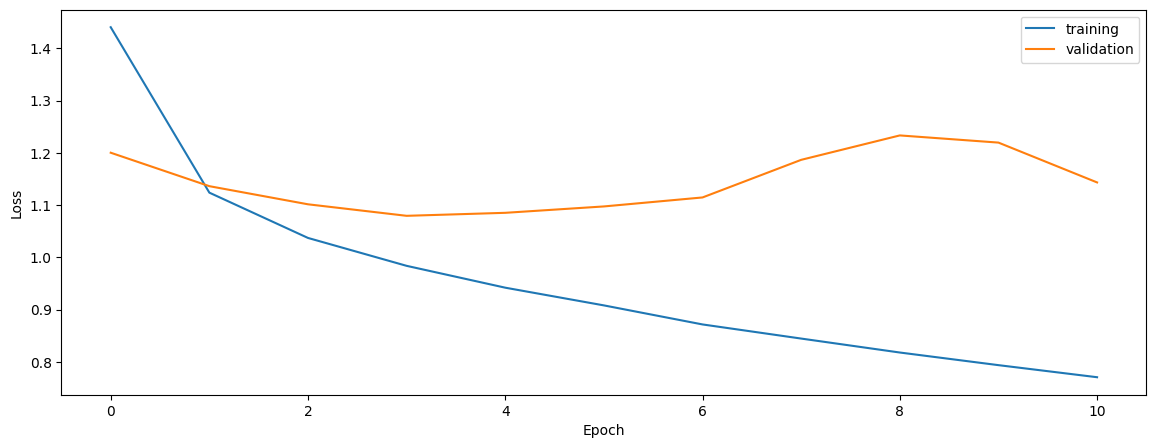

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6256661621807986
0.5759480040659511
0.5591367732507567


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5900342231348391
0.5850500215146299
0.5349243052222853


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5895067310922198
0.5790516008361756
0.5329732802728823


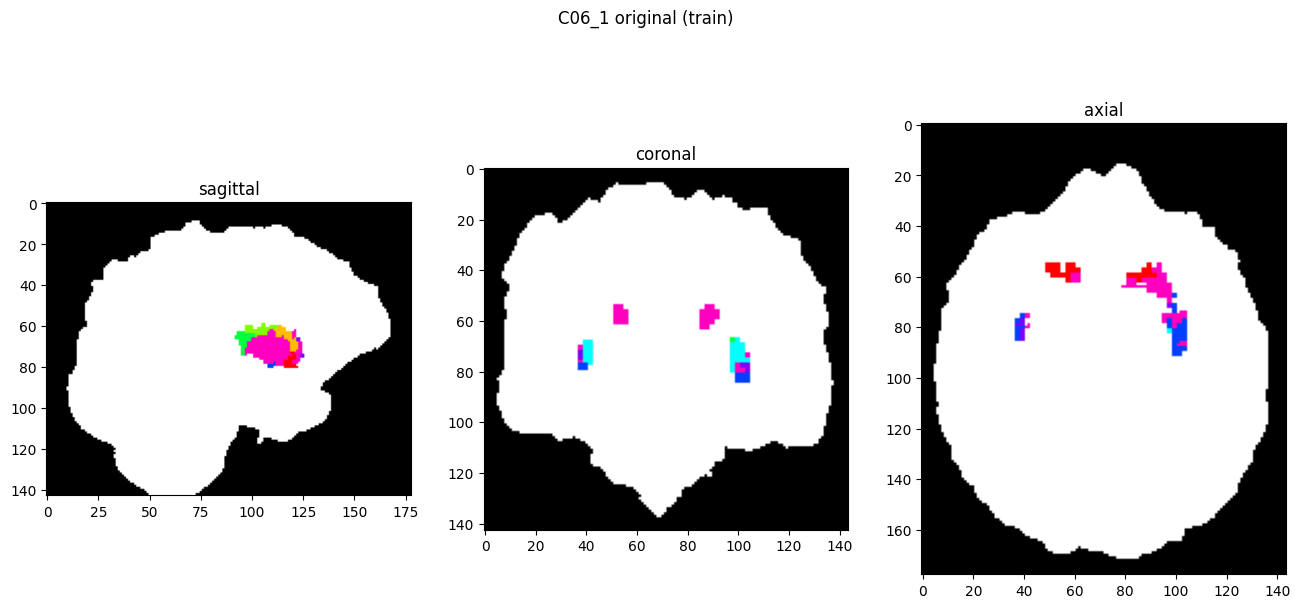

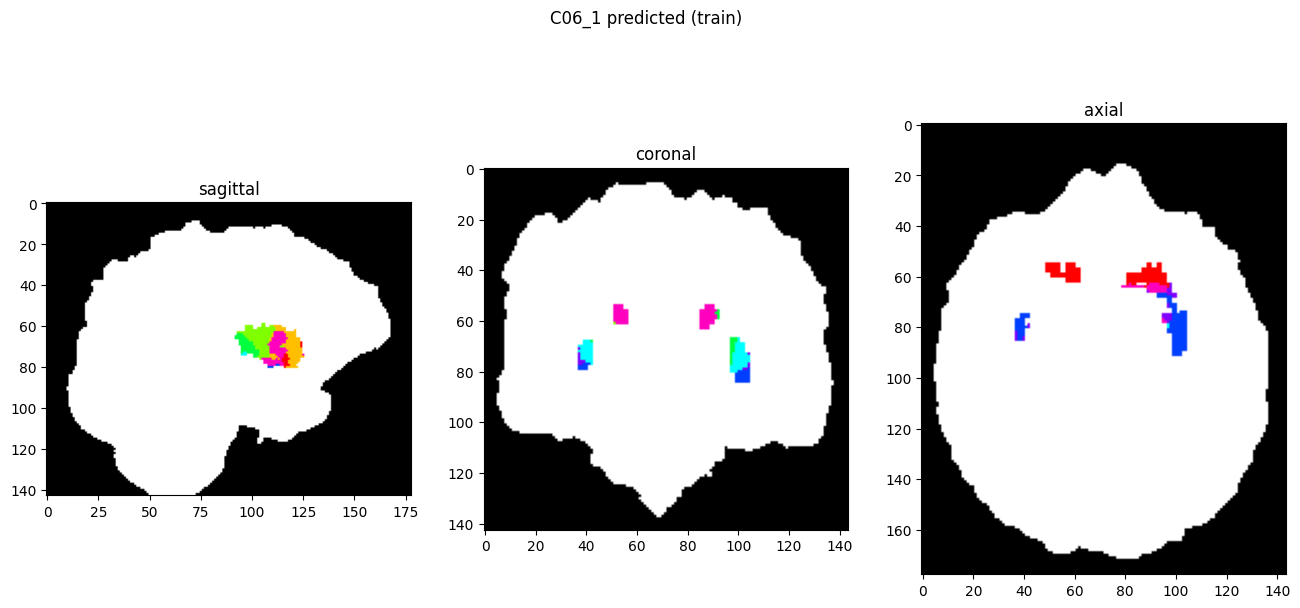

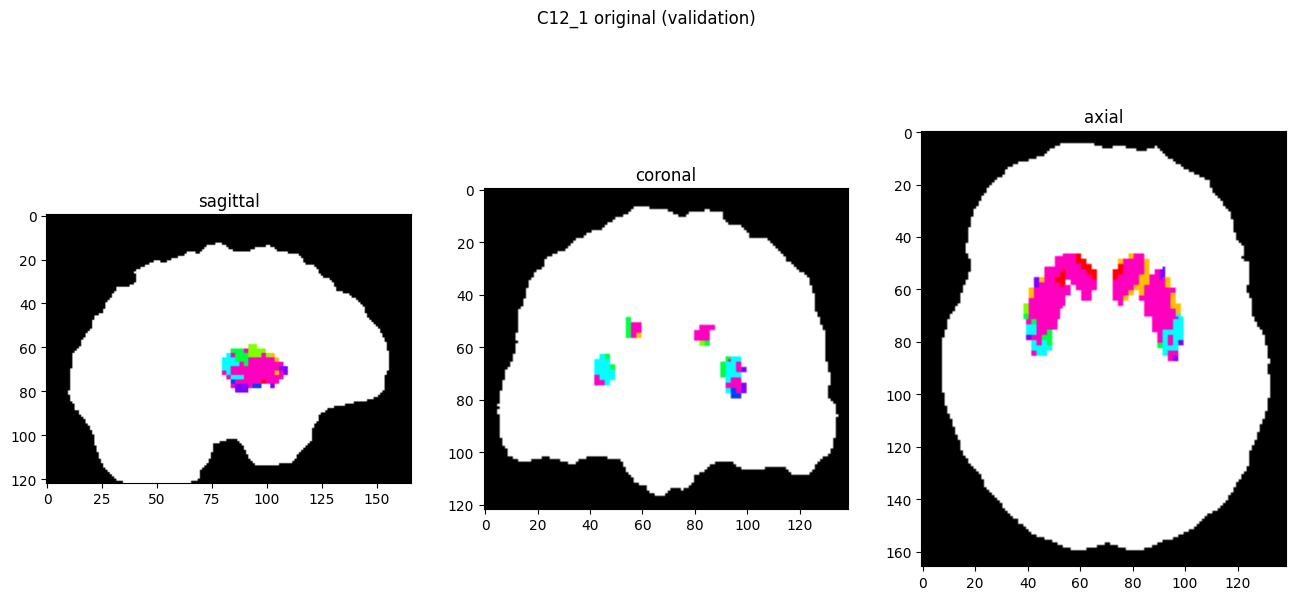

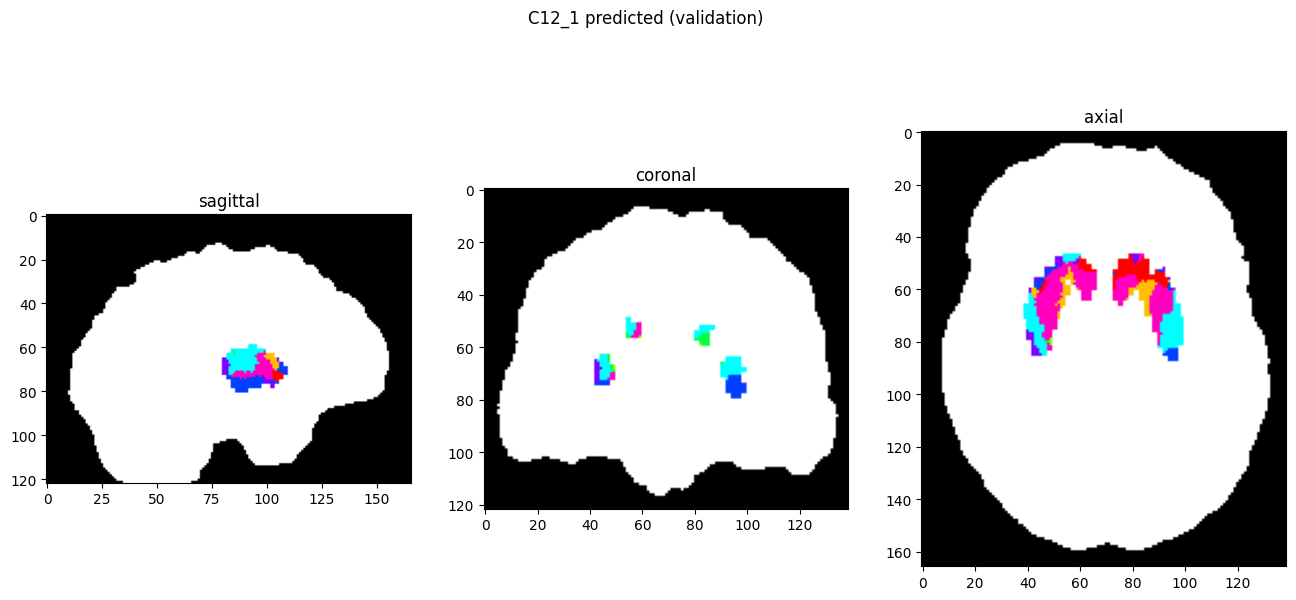

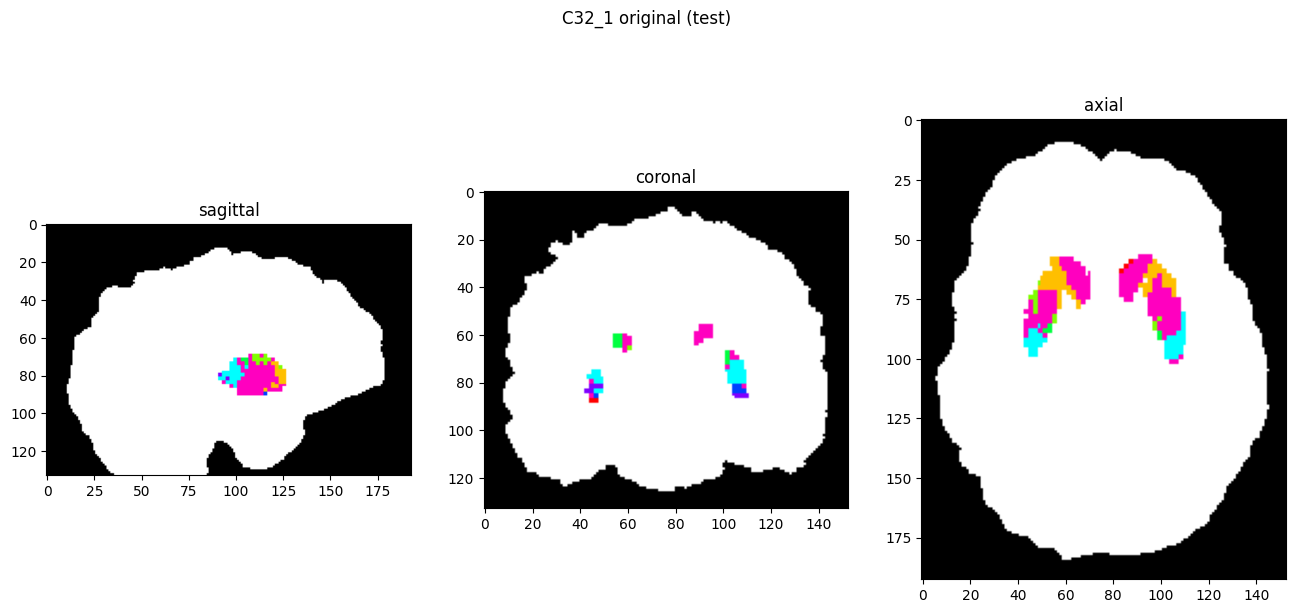

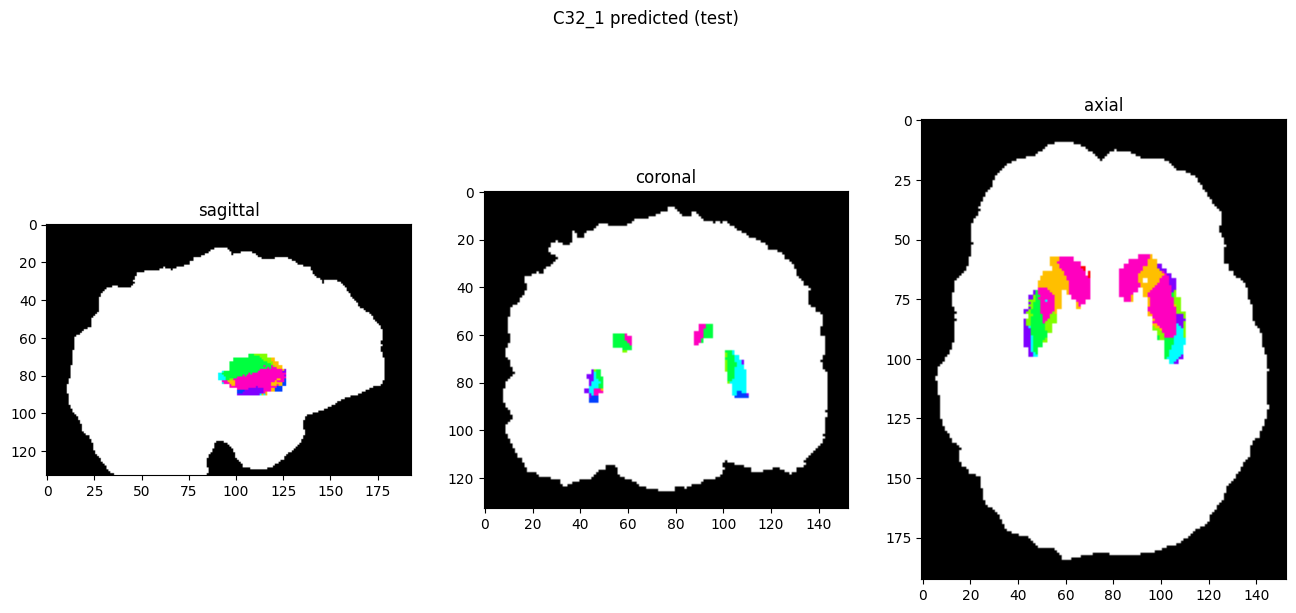

In [10]:
showResults(model, gen, threshold=0)